z

## Exploratory Data Analysis и линейная регрессия

### 5 баллов 
Дедлайн- 5.10

Задание -
Выделить полезные признаки и построить регрессионную модель

<strong style="color: red">Внимание!</strong> В этом ноутбуке используется библиотека `ipyleaflet`. Установить. (Работает только локально  в Jupyter.)

In [119]:
#!g2.1
#%%bash
#pip3 install ipyleaflet
#jupyter nbextension enable --py --sys-prefix ipyleaflet

In [120]:
#!g2.1
#from google.colab import output
#output.enable_custom_widget_manager()

После этого перезапустите сессию (не `Restart Kernel`, а нажмите `Ctrl+C` в терминале, где вы запускали ноутбук, и запустите заново). Лучше это сделать сразу, чтобы потом не пришлось прерывать сессию и терять промежуточные результаты работы. Если все сделано правильно, вы должны увидеть карту Москвы, выполнив ячейку ниже:

In [121]:
#!g2.1
#from ipyleaflet import Map, basemaps
#Map(center=(55.7522200, 37.6155600), zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

In [122]:
#!g2.1
# 0.5 doesn't support tooltip, must install dev instead
#!pip install git+https://github.com/python-visualization/folium

Для Colab используем folium

In [123]:
#!g2.1
#import folium

In [124]:
#!g2.1
#m = folium.Map(location=[55.7522200, 37.6155600])

In [125]:
#!g2.1
#m   # dsds

In [159]:
#!g2.1

%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import log

sns.set(style="darkgrid")

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.2 MB/s ta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


## 1) Подготовка данных

**Задание 1 **. Выборка- данные из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [160]:
#!g2.1
# Источник: https://github.com/nsadawi/Download-Large-File-From-Google-Drive-Using-Python
# Нужно, чтобы обойти страницу подтверждения скачивания большого файла с Google Drive
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive('1_mCpgxD4tFdUYcT2K9pcmwb8AhZpLt6V', 'train.csv')

#from google.colab import drive
#drive.mount('/content/drive')

In [161]:
#!g2.1
data = pd.read_csv('train.csv')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [162]:
#!g2.1
data.shape

(1458644, 11)

Столбцы `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` были добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Преобразуйте даты в `datetime`-объекты

In [163]:
#!g2.1
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [164]:
#!g2.1
data.drop('dropoff_datetime', axis=1, inplace=True)
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [165]:
#!g2.1
data.drop('id', axis=1, inplace=True) # Уникальный идентификатор поездки, не нужен

Целевое значение -`trip_duration`. Разбейте выборку на обучающую и тестовую в отношении 70% на 30%

In [166]:
#!g2.1
from sklearn.model_selection import train_test_split

def split_data(data, test_size):
    return train_test_split(data.drop('trip_duration', axis=1), data['trip_duration'], test_size=test_size, shuffle=False, stratify=None)

In [167]:
#!g2.1
# Преобразование категориальных признаков будет позже, пока просто уберем их
numeric_data = data._get_numeric_data()

x_train, x_test, y_train, y_test = split_data(numeric_data, 0.3)
x_train.shape, x_test.shape

((1021050, 6), (437594, 6))

Постройте распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

<AxesSubplot:>

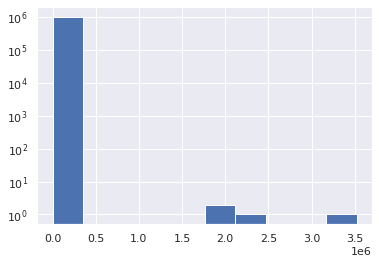

In [168]:
#!g2.1
y_train.hist(log=True)

**Сделайте вывод**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ:**

В обучающей выборке есть выбросы, значения целевой переменной на которых во много раз больше значений целевой переменной на остальных объектах.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?


**Задание**Постройте модель с оптимизациеЙ MSE

:

In [169]:
#!g2.1
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [170]:
#!g2.1
from sklearn.metrics import mean_squared_error

print('MSE на train:')
print(mean_squared_error(y_train, linear_regression_model.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, linear_regression_model.predict(x_test)))

MSE на train:
34809614.19617993
MSE на test:
10252846.847190823


**Сделайте выводы **

## 2.  `pickup_datetime` 

**Задание **. Посмотрите, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):


<AxesSubplot:xlabel='pickup_datetime', ylabel='count'>

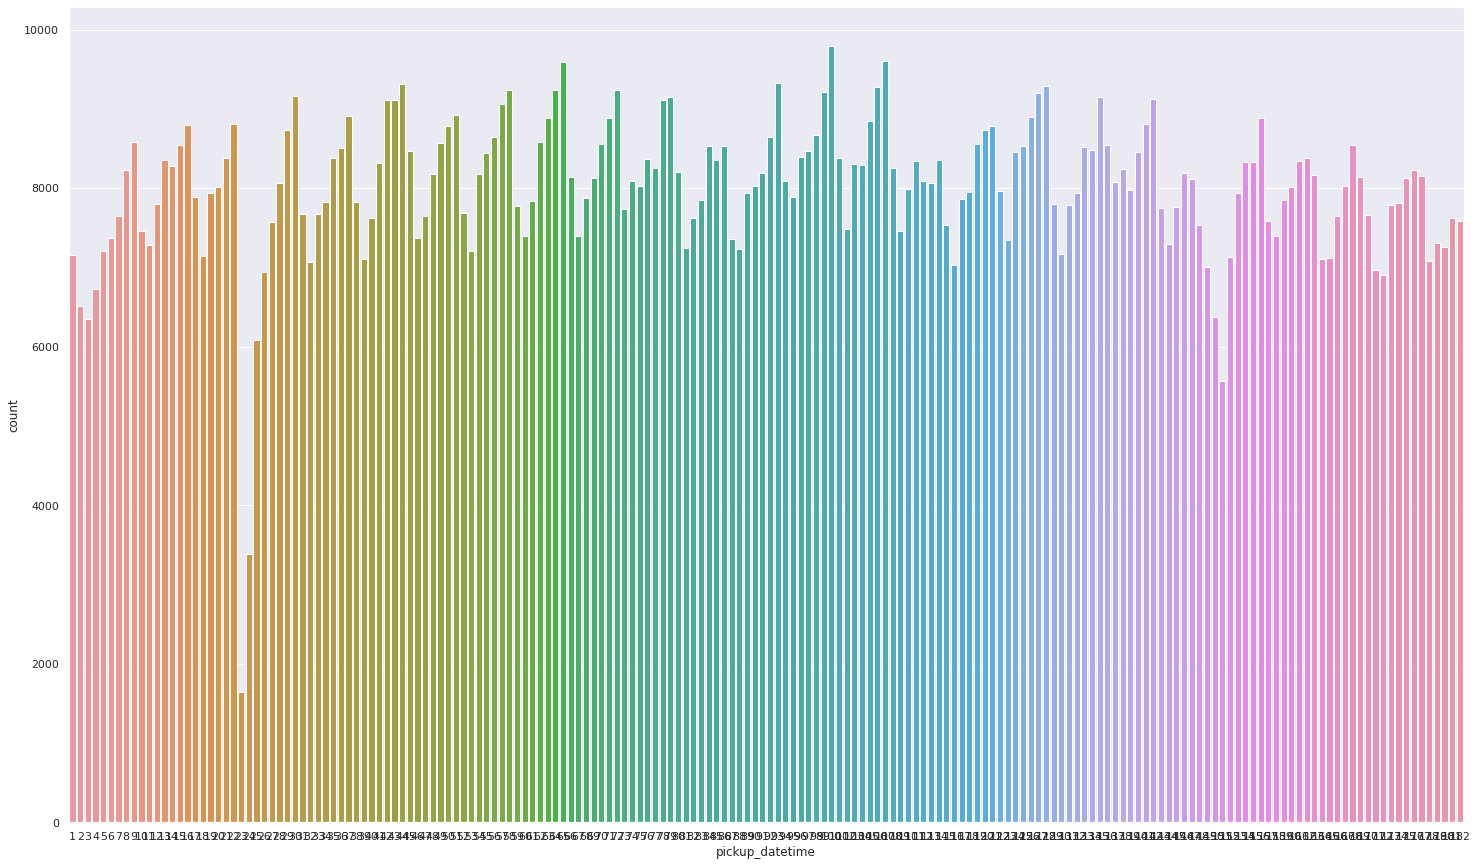

In [171]:
#!g2.1
days = data['pickup_datetime'].dt.dayofyear.to_frame()
#days_grouped = days.to_frame().groupby(['pickup_datetime']).size().to_frame('size').reset_index()
#days_grouped
sns.set(rc={'figure.figsize':(25,15)})
sns.countplot(x='pickup_datetime',data=days)
# days.hist(bins=366, figsize = (25,15))

In [172]:
#!g2.1
days_grouped = days.groupby(['pickup_datetime']).size().to_frame('size').reset_index()
days_grouped[days_grouped['size'] < 6000]

,pickup_datetime,size
22,23,1648
23,24,3383
150,151,5570


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**:

22-23 января 2016 — самая сильная метель в истории Нью-Йорка.

https://en.wikipedia.org/wiki/January_2016_United_States_blizzard

Метель привела к очень низкому количеству поездок 23 и 24 января.

Низкое количество поездок 30 мая (день 151), возможно, связано c Днем поминовения (Memorial Day) 31 мая 2021 (последний понедельник мая). Это — выходной день в США. Длинные выходные могли привести к уменьшению количества поездок. 

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

<AxesSubplot:>

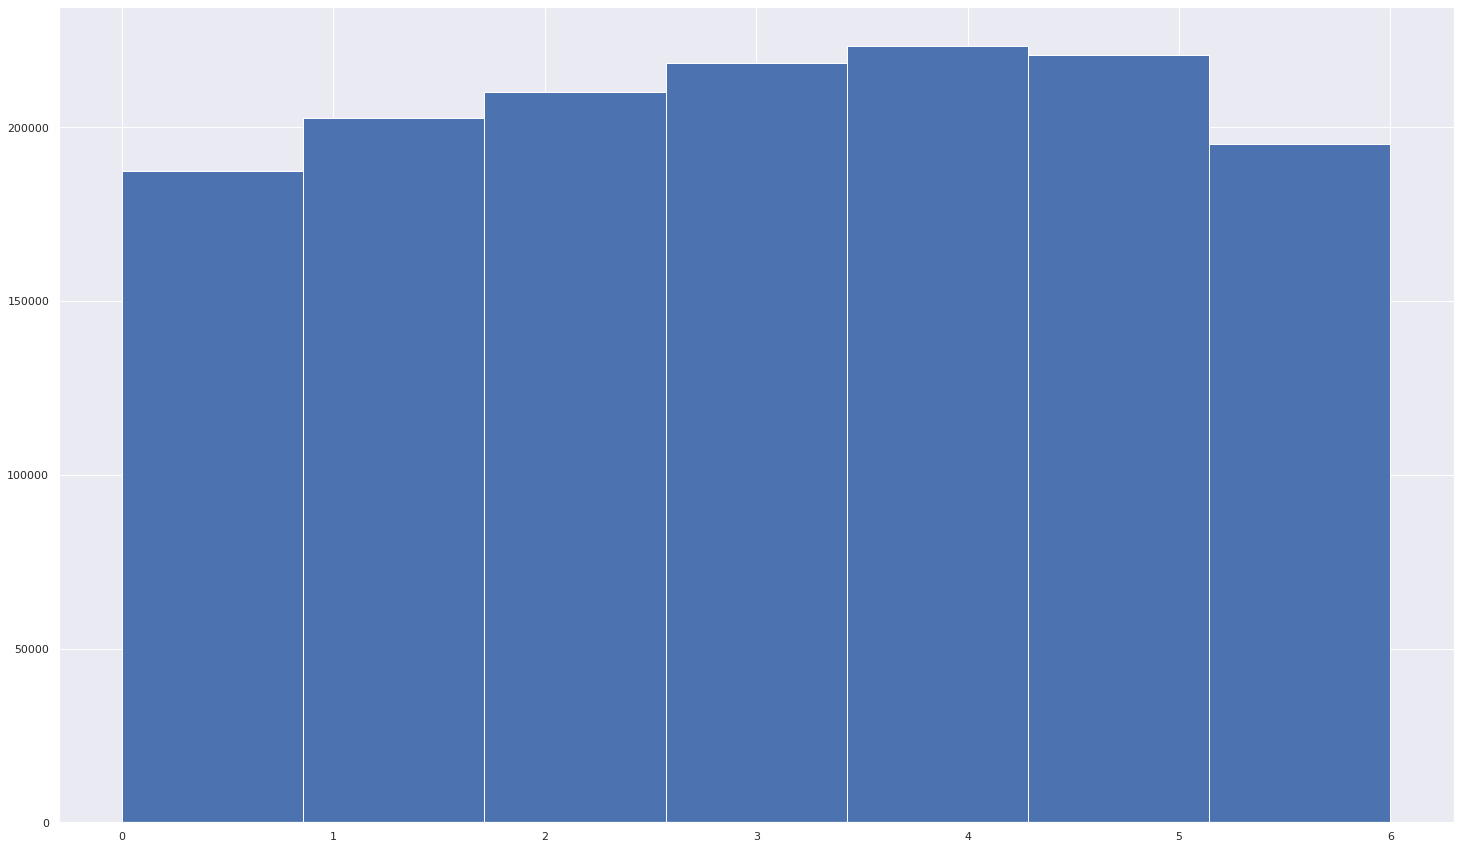

In [173]:
#!g2.1
days = data['pickup_datetime'].dt.dayofweek
days.hist(bins=7)
# Monday - 0 Sunday - 6

<AxesSubplot:>

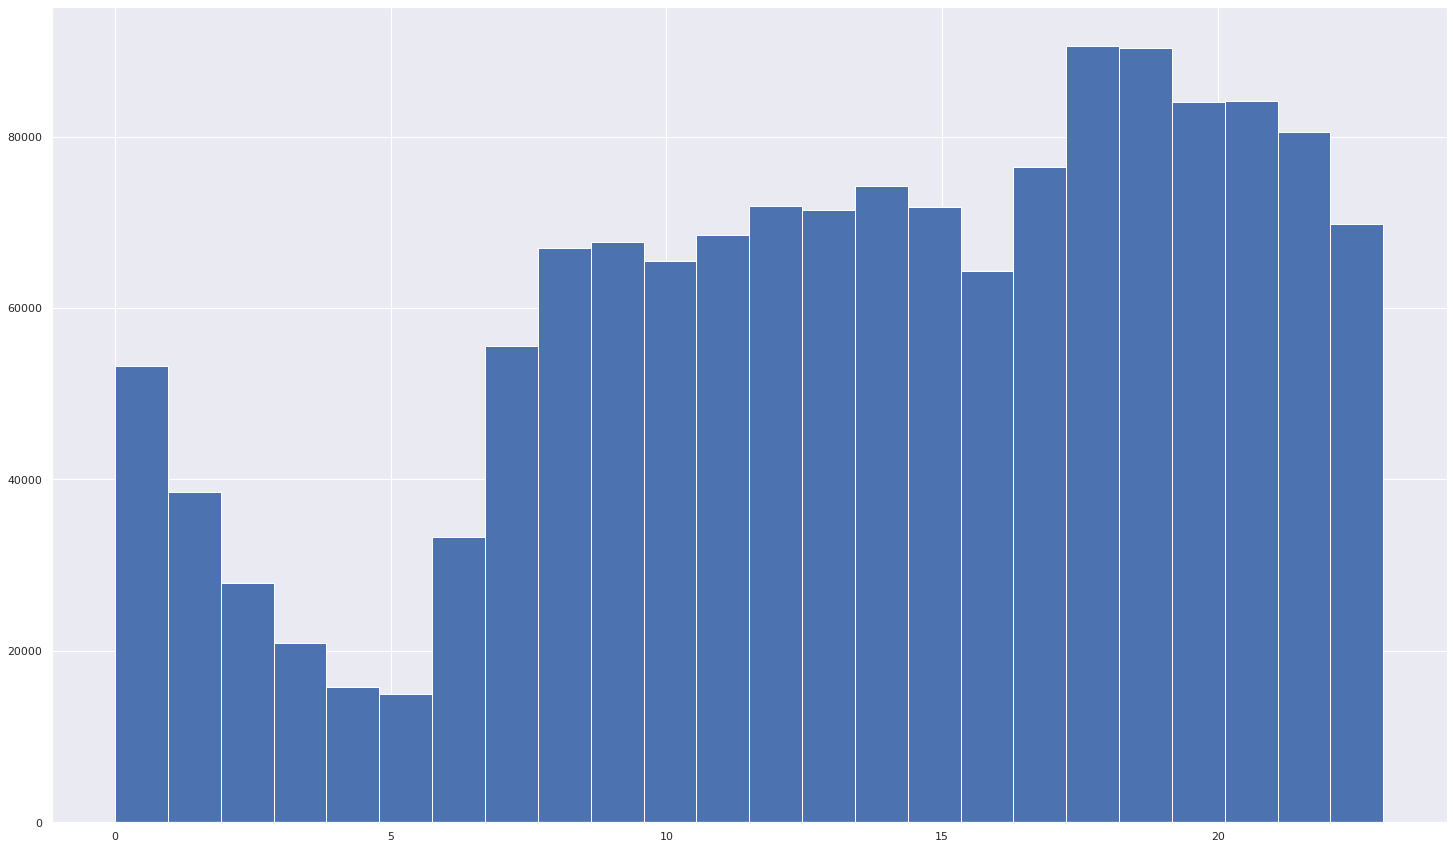

In [174]:
#!g2.1
hours = data['pickup_datetime'].dt.hour
hours.hist(bins=24)

**Задание**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [175]:
#!g2.1
data_with_temporary_columns = data.copy()
data_with_temporary_columns['months'] = data.apply(lambda x: x['pickup_datetime'].month, axis=1)
data_with_temporary_columns['hours'] = data.apply(lambda x: x['pickup_datetime'].hour, axis=1)
groupby_result = data_with_temporary_columns.groupby(['hours', 'months']).size().to_frame('size')
groupby_result

size
hours months       
0     1        8330
      2        8445
      3        8992
      4        9185
      5        9146
...             ...
23    2       11042
      3       12172
      4       12503
      5       11928
      6       11899

[144 rows x 1 columns]

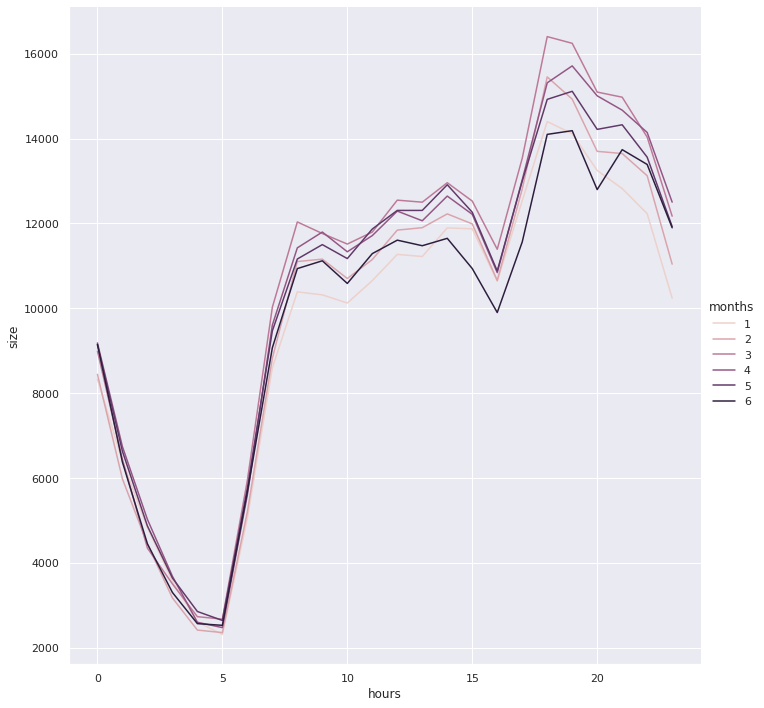

In [176]:
#!g2.1
sns.relplot(x='hours', y='size', hue='months', kind='line', data=groupby_result, height=10)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:**
Распределение количества поездок по времени суток мало зависит от месяца.
Количество поездок примерно одинаково с 8 до 17 часов.
В 18 и 19 часов количество поездок максимально.
Затем количество поездок постепенно снижается, достигая минимума в 5 часов утра.
Далее количество поездок возрастает.


**Задание **. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [177]:
#!g2.1
data_with_temporary_columns = data.copy()
data_with_temporary_columns['trip_duration_log'] = data.apply(lambda x: log(x['trip_duration']), axis=1)

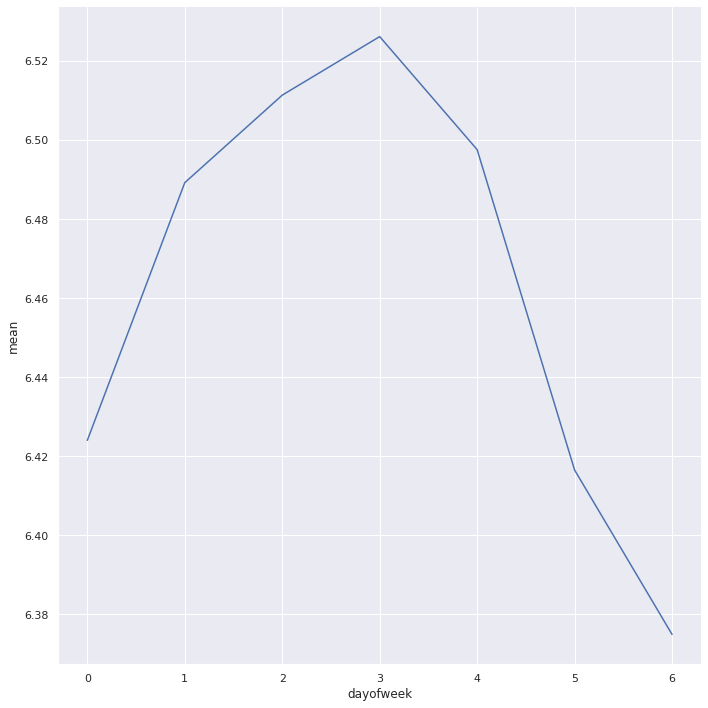

In [178]:
#!g2.1
data_with_temporary_columns['dayofweek'] = data.apply(lambda x: x['pickup_datetime'].dayofweek, axis=1)
dayofweek_groupby_result = data_with_temporary_columns.groupby(['dayofweek'])['trip_duration_log'].mean().to_frame('mean')
sns.relplot(x='dayofweek', y='mean', kind='line', data=dayofweek_groupby_result, height=10)

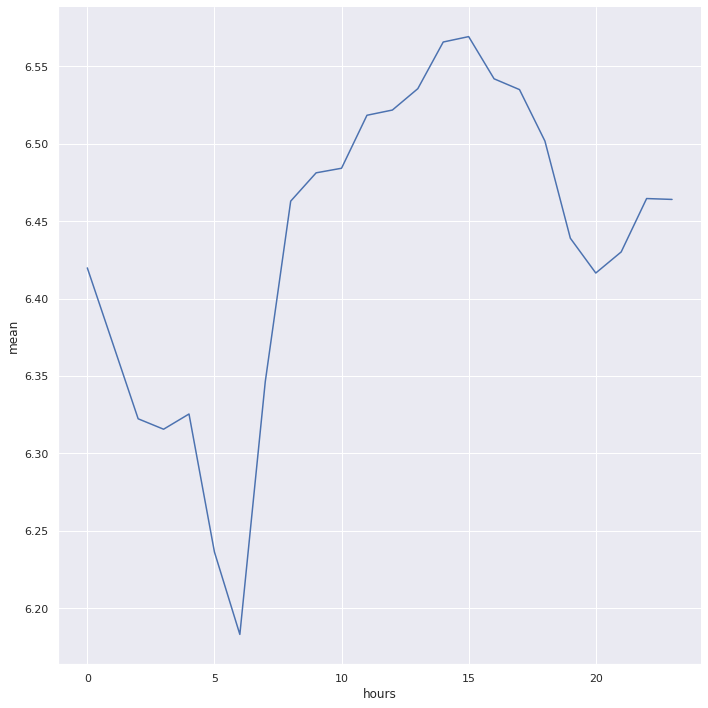

In [179]:
#!g2.1
data_with_temporary_columns['hours'] = data.apply(lambda x: x['pickup_datetime'].hour, axis=1)
hours_groupby_result = data_with_temporary_columns.groupby(['hours'])['trip_duration_log'].mean().to_frame('mean')
sns.relplot(x='hours', y='mean', kind='line', data=hours_groupby_result, height=10)

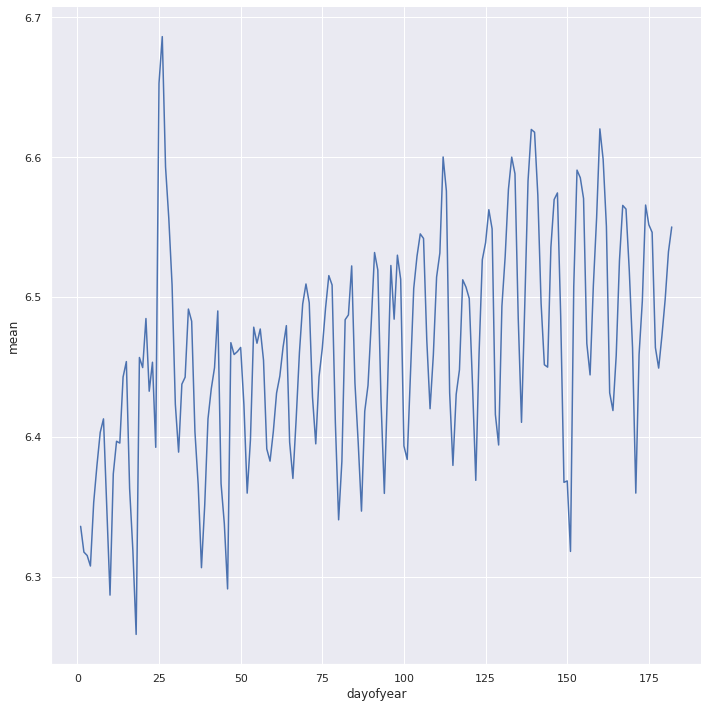

In [180]:
#!g2.1
data_with_temporary_columns['dayofyear'] = data.apply(lambda x: x['pickup_datetime'].dayofyear, axis=1)
dayofyear_groupby_result = data_with_temporary_columns.groupby(['dayofyear'])['trip_duration_log'].mean().to_frame('mean')
sns.relplot(x='dayofyear', y='mean', kind='line', data=dayofyear_groupby_result, height=10)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ:**
График зависимости логарифма среднего времени поездки от часа и дня недели очень похожи на соответствующие графики зависимости количества поездок. Вероятно, это вызвано загруженностью дорог. В то время, когда поездок больше, дороги более загружены.

На графике зависимости среднего времени поездки от номера дня в году заметен тренд. Среднее время поездки постепенно возрастает в течение года.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [181]:
#!g2.1
data['dayofweek'] = data.apply(lambda x: x['pickup_datetime'].dayofweek, axis=1)
data['month'] = data.apply(lambda x: x['pickup_datetime'].month, axis=1)
data['hour'] = data.apply(lambda x: x['pickup_datetime'].hour, axis=1)

data['dayofyear'] = data.apply(lambda x: x['pickup_datetime'].dayofyear, axis=1)
data['snowstorm'] = data.apply(lambda x: 1 if x['dayofyear'] in [23, 24] else 0, axis=1)
data['memorial_day'] = data.apply(lambda x: 1 if x['dayofyear'] == 151 else 0, axis=1)



**Отвеьте письменно на Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ:**
Для задачи линейной регрессии день недели, месяц, час и номер дня в году нужно считать категориальными признаками и, например, One Hot кодировать. Потому что зависимость между таргетом и номерами дня недели, месяца, часа и дня нелинейная.

Признак "Является ли период аномальным" можно считать численным с возможными значениями 0 и 1.

**Задание**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [182]:
#!g2.1
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def scale_and_one_hot_encode(data, target='trip_duration'):
	numeric_data = data._get_numeric_data().drop(target, axis=1)
	target = data[target].copy()
	standard_scaler = StandardScaler()
	scaled_data = standard_scaler.fit_transform(numeric_data)
	categorical_data = data.select_dtypes(['category'])
	one_hot_encoder = OneHotEncoder(sparse=False)
	one_hot_encoded = one_hot_encoder.fit_transform(categorical_data)
	scaled_data_df = pd.DataFrame(scaled_data, index=data.index, columns=numeric_data.columns)
	one_hot_encoded_df = pd.DataFrame(one_hot_encoded, index=data.index)
	return pd.concat([scaled_data_df, one_hot_encoded_df, target], axis=1)

def scale(data, target='trip_duration'):
	numeric_data = data._get_numeric_data().drop(target, axis=1)
	target = data[target].copy()
	standard_scaler = StandardScaler()
	scaled_data = standard_scaler.fit_transform(numeric_data)
	categorical_data = data.select_dtypes(['category'])
	scaled_data_df = pd.DataFrame(scaled_data, index=data.index, columns=numeric_data.columns)
	return pd.concat([scaled_data_df, categorical_data, target], axis=1)

def one_hot_encode(data, target='trip_duration'):
	numeric_data = data._get_numeric_data()
	categorical_data = data.select_dtypes(['category'])
	one_hot_encoder = OneHotEncoder(sparse=False)
	one_hot_encoded = one_hot_encoder.fit_transform(categorical_data)
	one_hot_encoded_df = pd.DataFrame(one_hot_encoded, index=data.index)
	return pd.concat([numeric_data, one_hot_encoded_df], axis=1)


In [183]:
#!g2.1
def split_data_scaled_encoded(data, test_size):
    scaled = scale(data)
    x_train, y_train, x_test, y_test = train_test_split(data.drop('trip_duration', axis=1), data['trip_duration'], test_size=test_size, random_state=13)
    return one_hot_encode(x_train), y_train, one_hot_encode(y_test), y_test

In [184]:
#!g2.1
x_train, x_test, y_train, y_test = split_data(scale_and_one_hot_encode(data), 0.3)

In [185]:
#!g2.1
x_train

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dayofweek,month,hour,dayofyear,snowstorm,memorial_day
0,0.932380,-0.505637,-0.122261,0.517494,0.124369,0.384575,-1.561062,-0.307440,0.530263,-0.345888,-0.058831,-0.061913
1,-1.072524,-0.505637,-0.097727,-0.375819,-0.368970,-0.575303,1.509502,1.477173,-2.126116,1.399446,-0.058831,-0.061913
2,0.932380,-0.505637,-0.078143,0.395910,-0.451805,-1.162220,-1.049301,-1.497182,-0.407283,-1.412481,-0.058831,-0.061913
3,0.932380,-0.505637,-0.515558,-0.941274,-0.549976,-1.256071,-0.537541,0.287431,0.842778,0.100142,-0.058831,-0.061913
4,0.932380,-0.505637,0.006112,1.286091,0.006974,0.855957,0.997741,-0.307440,-0.094768,-0.113177,-0.058831,-0.061913
...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,-1.072524,-0.505637,-0.211896,0.108542,-0.137097,0.832362,-0.537541,0.882302,1.467808,0.643135,-0.058831,-0.061913
1021046,-1.072524,-0.505637,0.117806,0.262029,0.247704,0.612029,1.509502,0.287431,0.217747,0.041964,-0.058831,-0.061913
1021047,-1.072524,0.255258,-0.090087,0.152744,-0.177488,-0.032495,0.997741,-1.497182,0.686520,-1.470659,-0.058831,-0.061913
1021048,0.932380,-0.505637,-0.144213,-0.394381,-0.320911,-0.206912,-1.561062,-1.497182,-1.032313,-1.567622,-0.058831,-0.061913


In [186]:
#!g2.1


In [187]:
#!g2.1
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [188]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, ridge.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, ridge.predict(x_test)))

MSE на train:
34808083.65553133
MSE на test:
10251026.030274047


## 3. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [189]:
#!g2.1
#from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [190]:
#!g2.1
# def show_circles_on_map(data, latitude_column, longitude_column, color):
#     """
#     The function draws map with circles on it.
#     The center of the map is the mean of coordinates passed in data.
    
#     data: DataFrame that contains columns latitude_column and longitude_column
#     latitude_column: string, the name of column for latitude coordinates
#     longitude_column: string, the name of column for longitude coordinates
#     color: string, the color of circles to be drawn
#     """

#     center = (data[latitude_column].mean(), data[longitude_column].mean())
#     result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

#     circles = []
#     for _, row in data.iterrows():
#         circles.append(Circle(
#             location=(row[latitude_column], row[longitude_column]),
#             fill_color=color,
#             fill_opacity=0.2,
#             radius=300,
#             stroke=False
#         ))
#     circles_layer = LayerGroup(layers=circles)
#     result_map.add_layer(circles_layer)

#     return result_map

In [191]:
#!g2.1
#show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [192]:
#!g2.1
#show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ:** Аэропорты La Guardia и John F. Kennedy.

**Задание**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [193]:
#!g2.1
from sklearn.metrics.pairwise import haversine_distances
from math import radians, fabs

def haversine(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
     # = radians(row['pickup_latitude'])
     # = radians(row['pickup_longitude'])
     # = radians(row['dropoff_latitude'])
     # = radians(row['dropoff_longitude'])
    return fabs(haversine_distances([[radians(pickup_latitude), radians(pickup_longitude)], [radians(dropoff_latitude), radians(dropoff_longitude)]])[0, 1] * 6371000/1000)


data['haversine'] = data.apply(lambda x: haversine(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
data = data[data['haversine'] > 0].copy()

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [194]:
#!g2.1
data['haversine_log'] = data.apply(lambda x: log(x['haversine']), axis=1)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [195]:
#!g2.1
data['haversine'].corr(data['trip_duration'])

0.094664734582527

In [196]:
#!g2.1
data['haversine_log'].corr(data['trip_duration'])

0.09293481839134439

**Задание**. Изучите среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<AxesSubplot:>

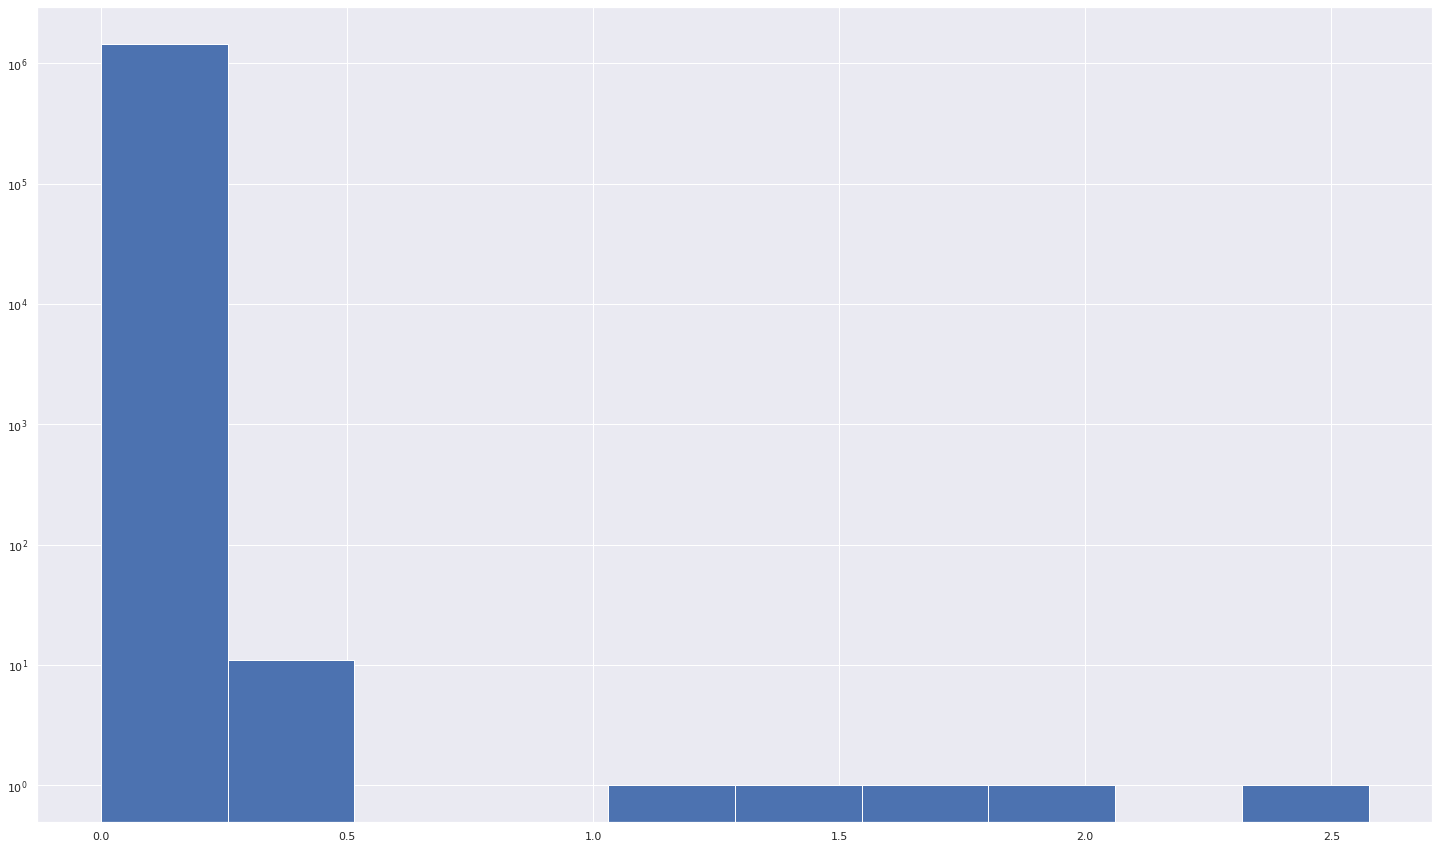

In [197]:
#!g2.1
data['velocity'] = data['haversine'] / data['trip_duration']
data['velocity'].hist(log=True)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<AxesSubplot:>

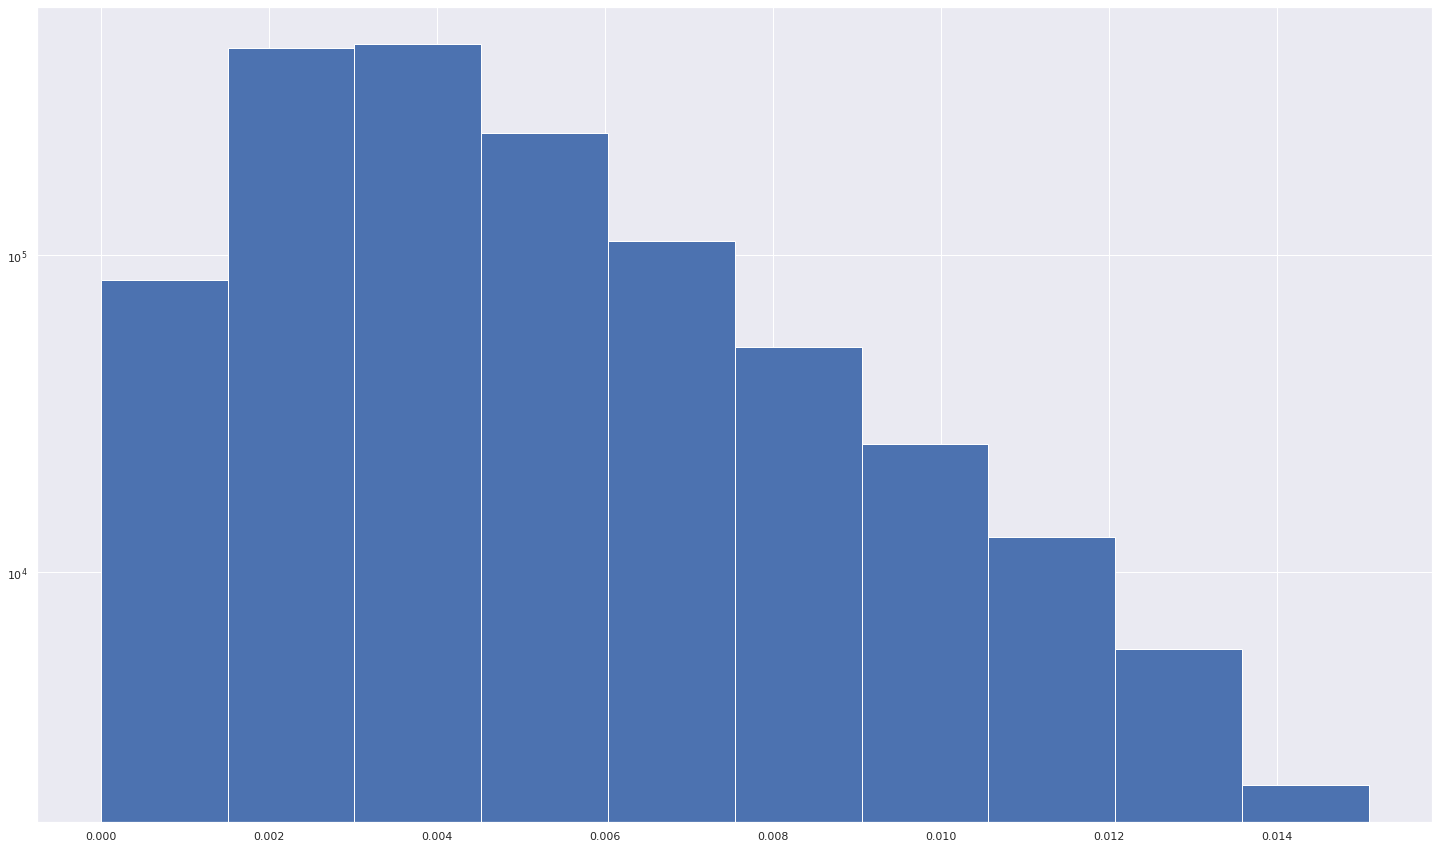

In [198]:
#!g2.1
velocity_quantile = data['velocity'].quantile(0.999)
data = data[data['velocity'] < velocity_quantile].copy()
data['velocity'].hist(log=True)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [199]:
#!g2.1
day_hour_groupby_result = data.groupby(['dayofweek', 'hour'])['velocity'].median()
unstacked = day_hour_groupby_result.unstack(level=0)
unstacked

dayofweek,0,1,2,3,4,5,6
hour,,,,,,,
0,0.005568,0.005235,0.004969,0.004811,0.004451,0.003925,0.003980
1,0.005615,0.005559,0.005400,0.005299,0.004825,0.004317,0.004282
2,0.005751,0.005675,0.005586,0.005527,0.005033,0.004528,0.004600
3,0.005735,0.006064,0.005783,0.005859,0.005266,0.004859,0.004889
4,0.006596,0.006422,0.006330,0.006258,0.005809,0.005307,0.005203
5,0.006545,0.006332,0.006286,0.006152,0.006308,0.006300,0.006134
6,0.005252,0.005028,0.005081,0.005118,0.005217,0.006118,0.006598
7,0.004031,0.003753,0.003745,0.003758,0.003855,0.005441,0.005905
8,0.003195,0.002890,0.002928,0.002891,0.003006,0.004757,0.005164


<AxesSubplot:xlabel='dayofweek', ylabel='hour'>

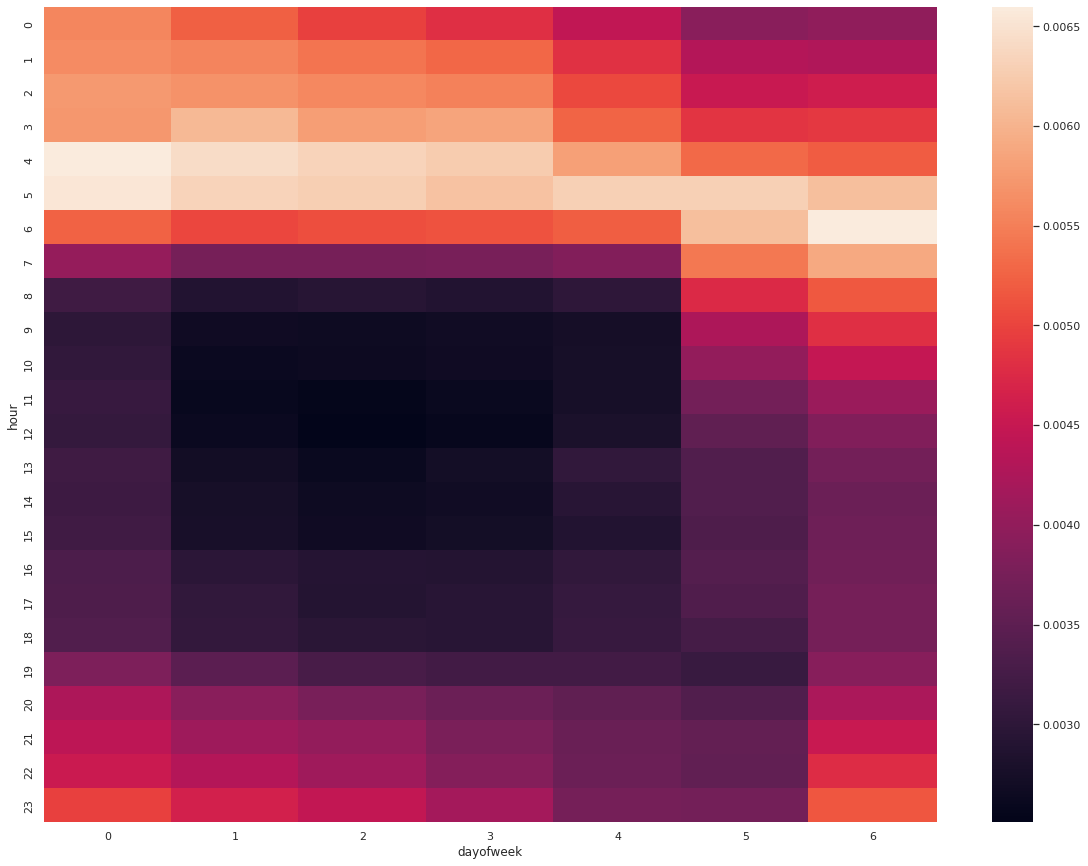

In [200]:
#!g2.1
plt.subplots(figsize=(20,15))
sns.heatmap(unstacked)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ:** Потому что скорость зависит от таргета - времени поездки. Посчитать скорость для датесета, где нам неизвестно время поездки и хотим его предсказать - невозможно.

In [201]:
#!g2.1
velocity = data['velocity']
data.drop('velocity', axis=1, inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ:**
Скорость минимальна в то же время, когда количество поездок максимально. Похоже, в это время люди активнее перемещаются по городу, и не только на такси, и загруженность дорог высока.

Аналогично - для времени с малым количествоп поездок.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [202]:
#!g2.1
day_hour_groupby_result_df = day_hour_groupby_result.to_frame('median')
day_hour_groupby_result_df

median
dayofweek hour          
0         0     0.005568
          1     0.005615
          2     0.005751
          3     0.005735
          4     0.006596
...                  ...
6         19    0.003914
          20    0.004247
          21    0.004525
          22    0.004792
          23    0.005144

[168 rows x 1 columns]

In [203]:
#!g2.1
quantile_lower = day_hour_groupby_result_df['median'].quantile(0.1)
quantile_upper = day_hour_groupby_result_df['median'].quantile(0.9)
data['time_of_busy_roads'] = data.apply(lambda x: 1 if unstacked.iat[x['pickup_datetime'].hour, x['pickup_datetime'].dayofweek] < quantile_lower else 0, axis=1)
data['time_of_free_roads'] = data.apply(lambda x: 1 if unstacked.iat[x['pickup_datetime'].hour, x['pickup_datetime'].dayofweek] > quantile_upper else 0, axis=1)

data.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,month,hour,dayofyear,snowstorm,memorial_day,haversine,haversine_log,time_of_busy_roads,time_of_free_roads
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,17,74,0,0,1.498521,0.404478,0,0
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,0,164,0,0,1.805507,0.590842,0,0
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,11,19,0,0,6.385098,1.853967,1,0
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,4,19,97,0,0,1.485498,0.395750,0,0
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,3,13,86,0,0,1.188588,0.172766,0,0


**Задание**. Как уже было замечено выше, на карте выделяются две точки - аэропорты La Guardia и John F Kennedy. Для каждого из аэропортов добавьте в выборки два признака: началась ли поездка из этого аэропорта и закончилась ли поездка в этом аэропорту.

In [204]:
#!g2.1
la_guardia_lat = 40.77268
la_guardia_lon = -73.87238

kennedy_lat = 40.64509
kennedy_lon = -73.78695

airport_radius = 1.3

data['from_la_guardia'] = data.apply(lambda x: 1 if haversine(la_guardia_lat, la_guardia_lon, x['pickup_latitude'], x['pickup_longitude']) < airport_radius else 0, axis=1)
data['to_la_guardia'] = data.apply(lambda x: 1 if haversine(la_guardia_lat, la_guardia_lon, x['dropoff_latitude'], x['dropoff_longitude']) < airport_radius else 0, axis=1)

data['from_kennedy'] = data.apply(lambda x: 1 if haversine(kennedy_lat, kennedy_lon, x['pickup_latitude'], x['pickup_longitude']) < airport_radius else 0, axis=1)
data['to_kennedy'] = data.apply(lambda x: 1 if haversine(kennedy_lat, kennedy_lon, x['dropoff_latitude'], x['dropoff_longitude']) < airport_radius else 0, axis=1)


In [205]:
#!g2.1
data.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,...,snowstorm,memorial_day,haversine,haversine_log,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,...,0,0,1.498521,0.404478,0,0,0,0,0,0
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,...,0,0,1.805507,0.590842,0,0,0,0,0,0
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,...,0,0,6.385098,1.853967,1,0,0,0,0,0
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,...,0,0,1.485498,0.395750,0,0,0,0,0,0
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,...,0,0,1.188588,0.172766,0,0,0,0,0,0


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [206]:
#!g2.1
data = data[data['trip_duration'] > 0].copy()
data['trip_duration_log'] = data.apply(lambda x: log(x['trip_duration']), axis=1)

<AxesSubplot:xlabel='trip_duration_log'>

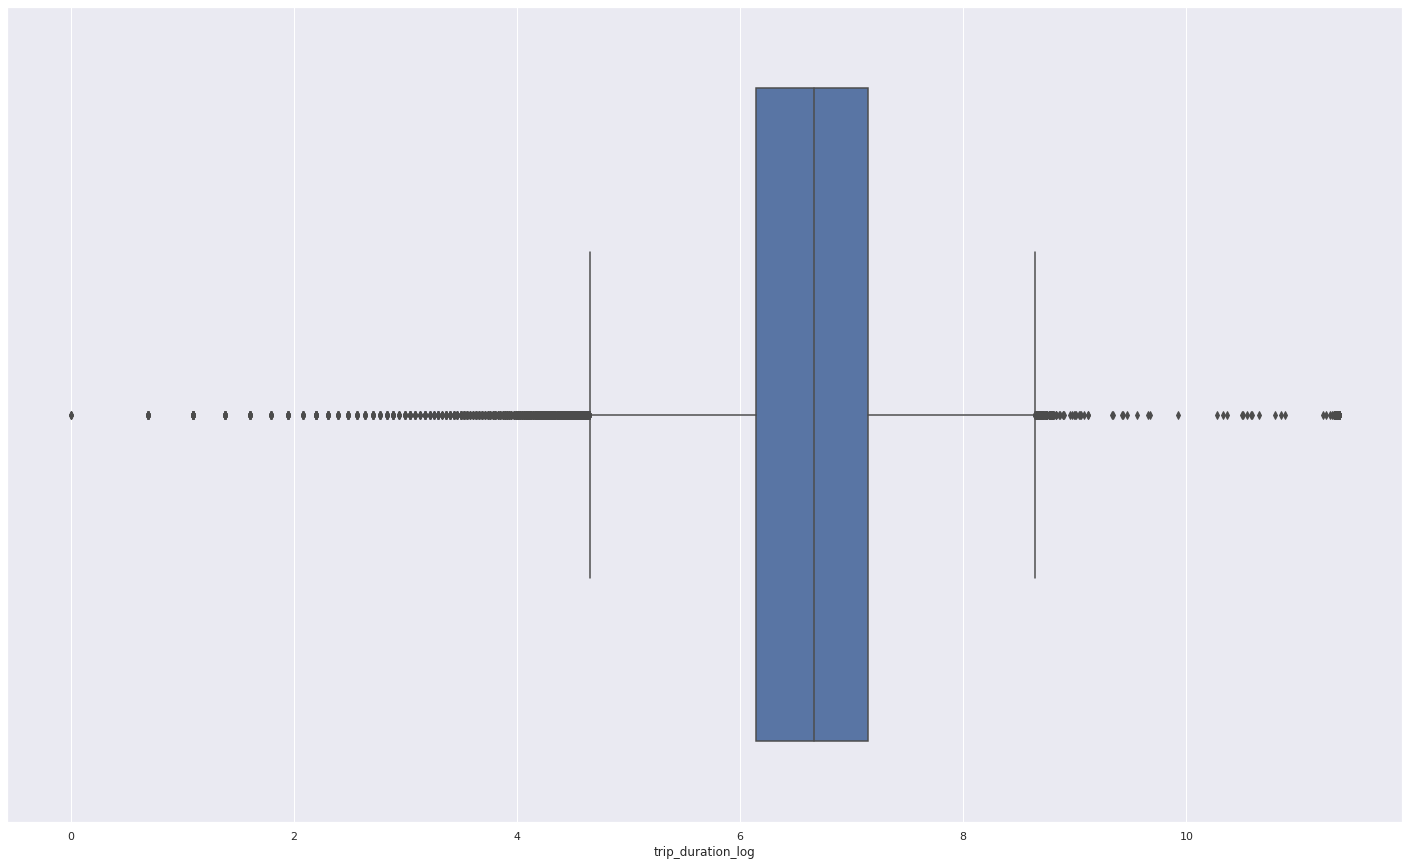

In [207]:
#!g2.1
when_busy_roads = data[data['time_of_busy_roads'] == 1]
sns.boxplot(x='trip_duration_log', data=when_busy_roads)

<AxesSubplot:xlabel='trip_duration_log'>

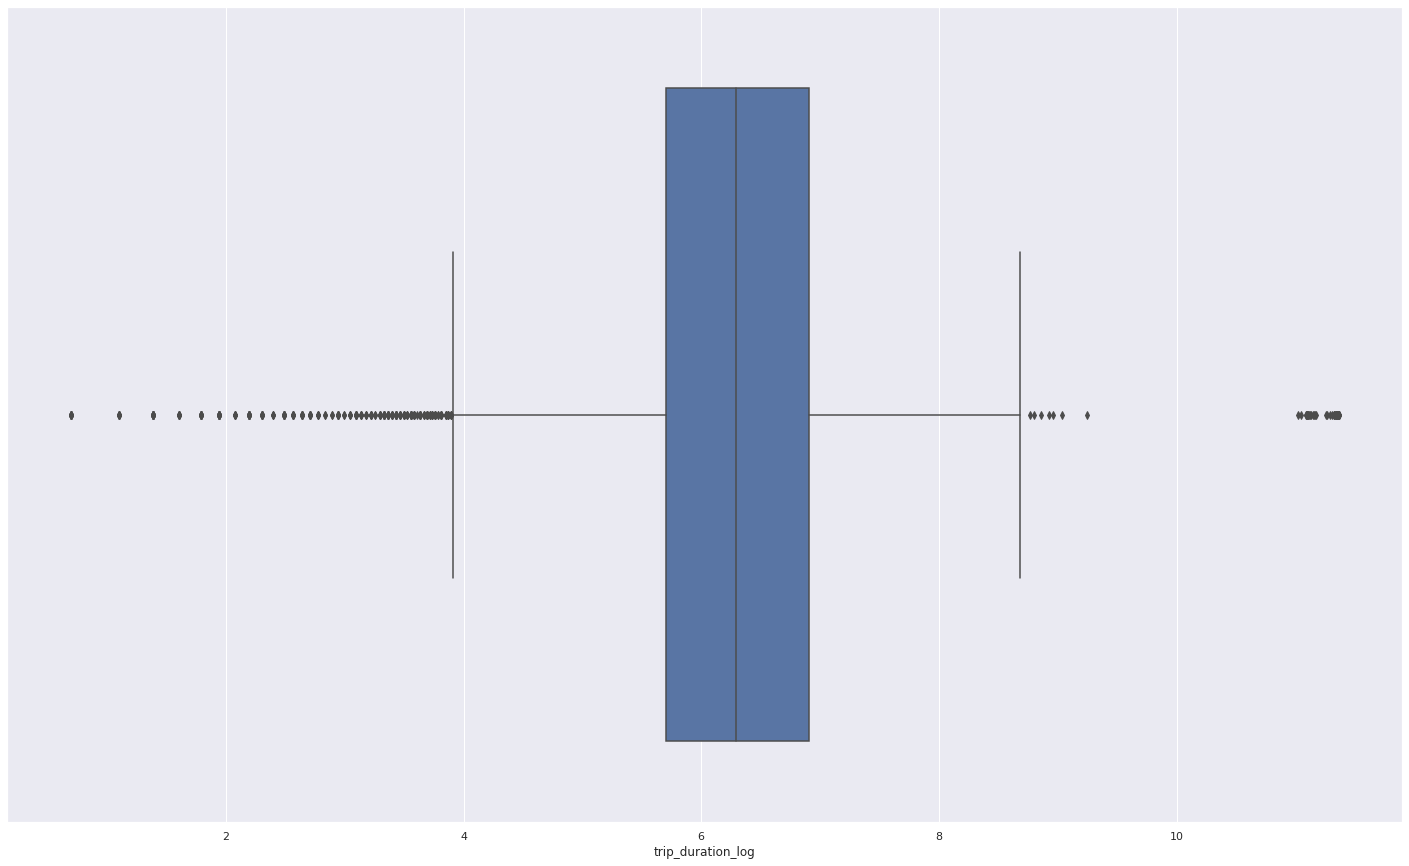

In [208]:
#!g2.1
when_free_roads = data[data['time_of_free_roads'] == 1]
sns.boxplot(x='trip_duration_log', data=when_free_roads)

<AxesSubplot:xlabel='trip_duration_log'>

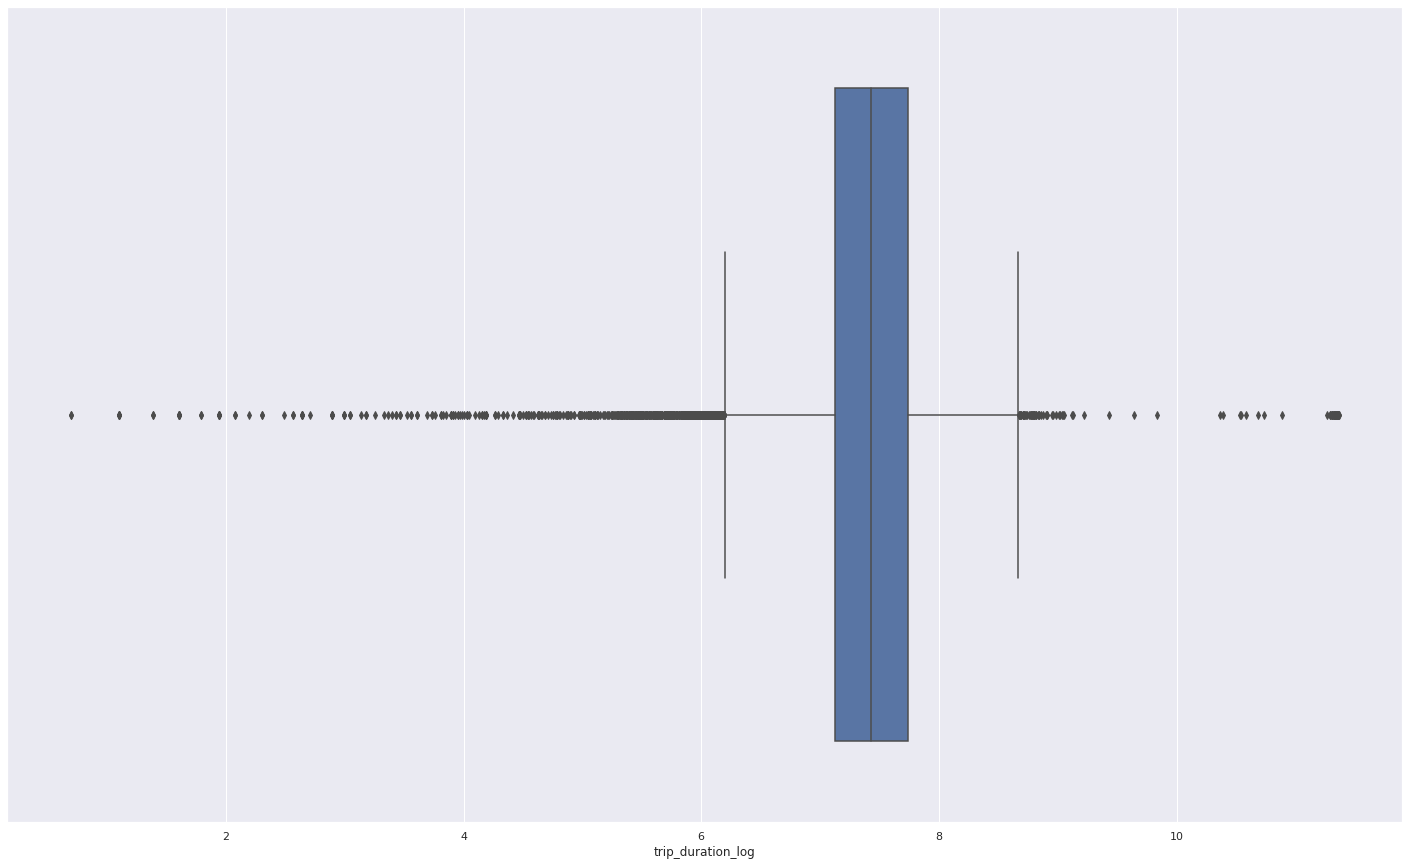

In [209]:
#!g2.1
from_la_guardia = data[data['from_la_guardia'] == 1]
sns.boxplot(x='trip_duration_log', data=from_la_guardia)

<AxesSubplot:xlabel='trip_duration_log'>

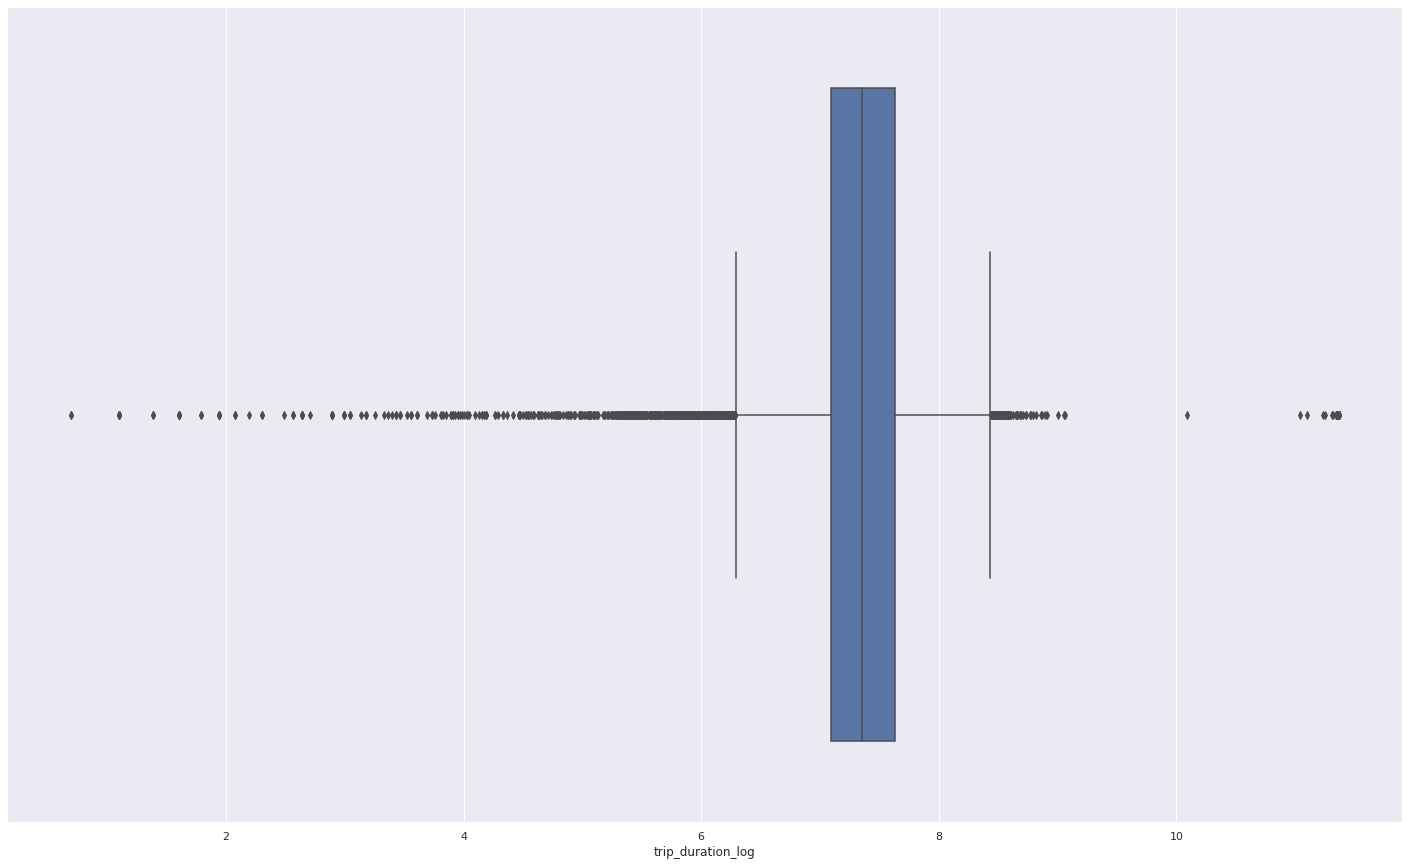

In [210]:
#!g2.1
to_la_guardia = data[data['to_la_guardia'] == 1]
sns.boxplot(x='trip_duration_log', data=to_la_guardia)

<AxesSubplot:xlabel='trip_duration_log'>

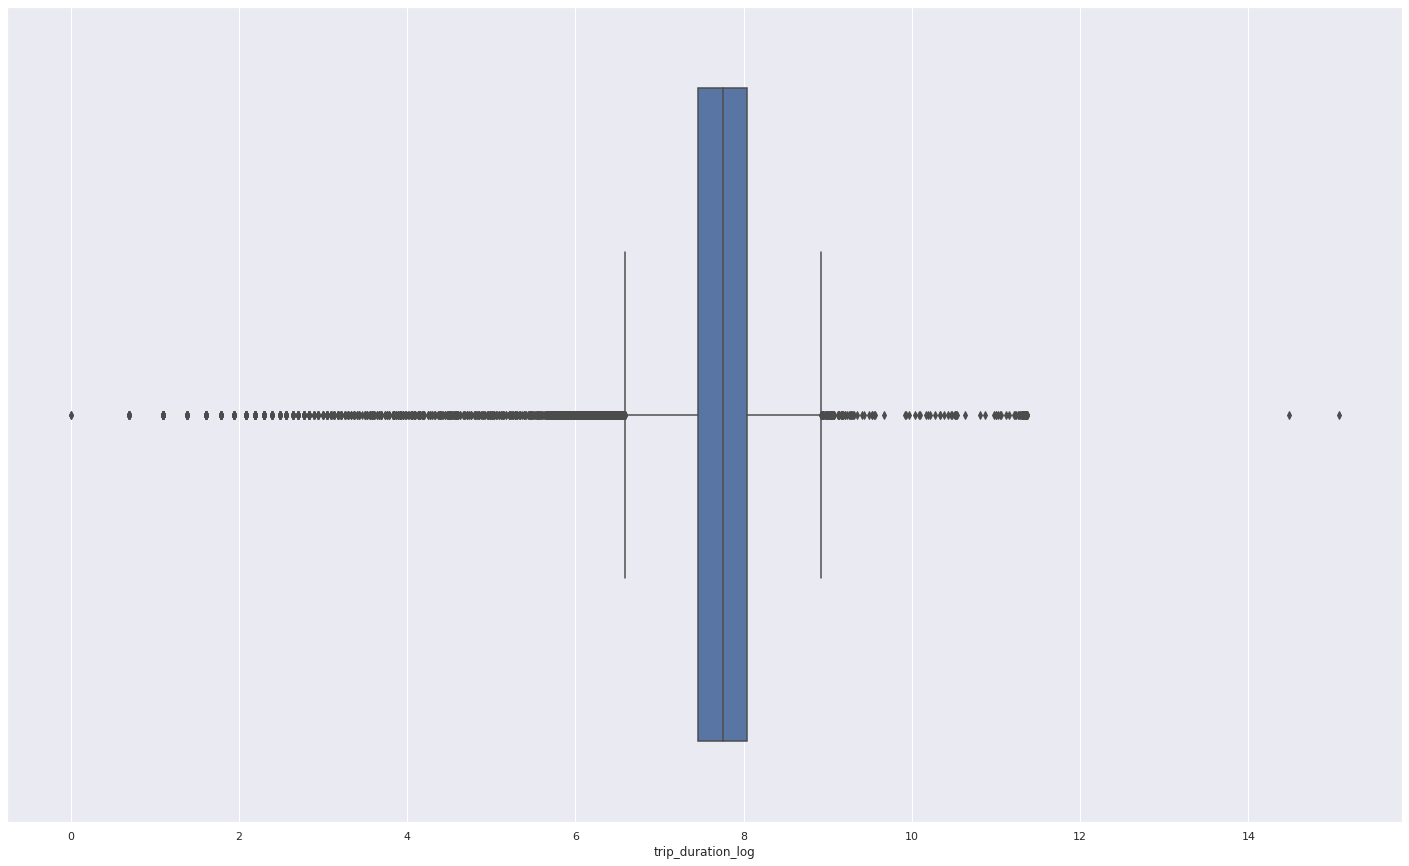

In [211]:
#!g2.1
from_kennedy = data[data['from_kennedy'] == 1]
sns.boxplot(x='trip_duration_log', data=from_kennedy)

<AxesSubplot:xlabel='trip_duration_log'>

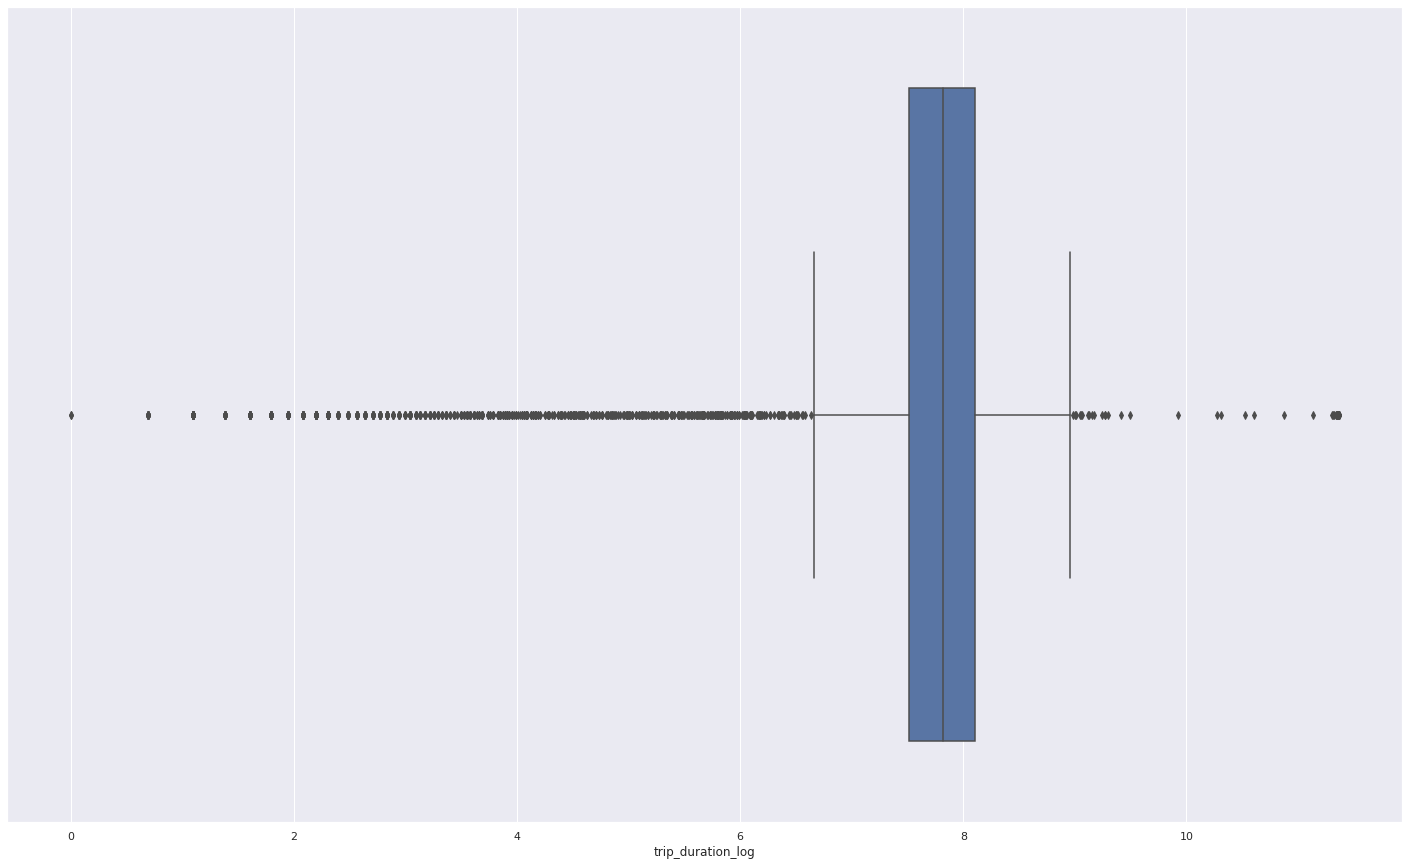

In [212]:
#!g2.1
to_kennedy = data[data['to_kennedy'] == 1]
sns.boxplot(x='trip_duration_log', data=to_kennedy)

<AxesSubplot:xlabel='trip_duration_log'>

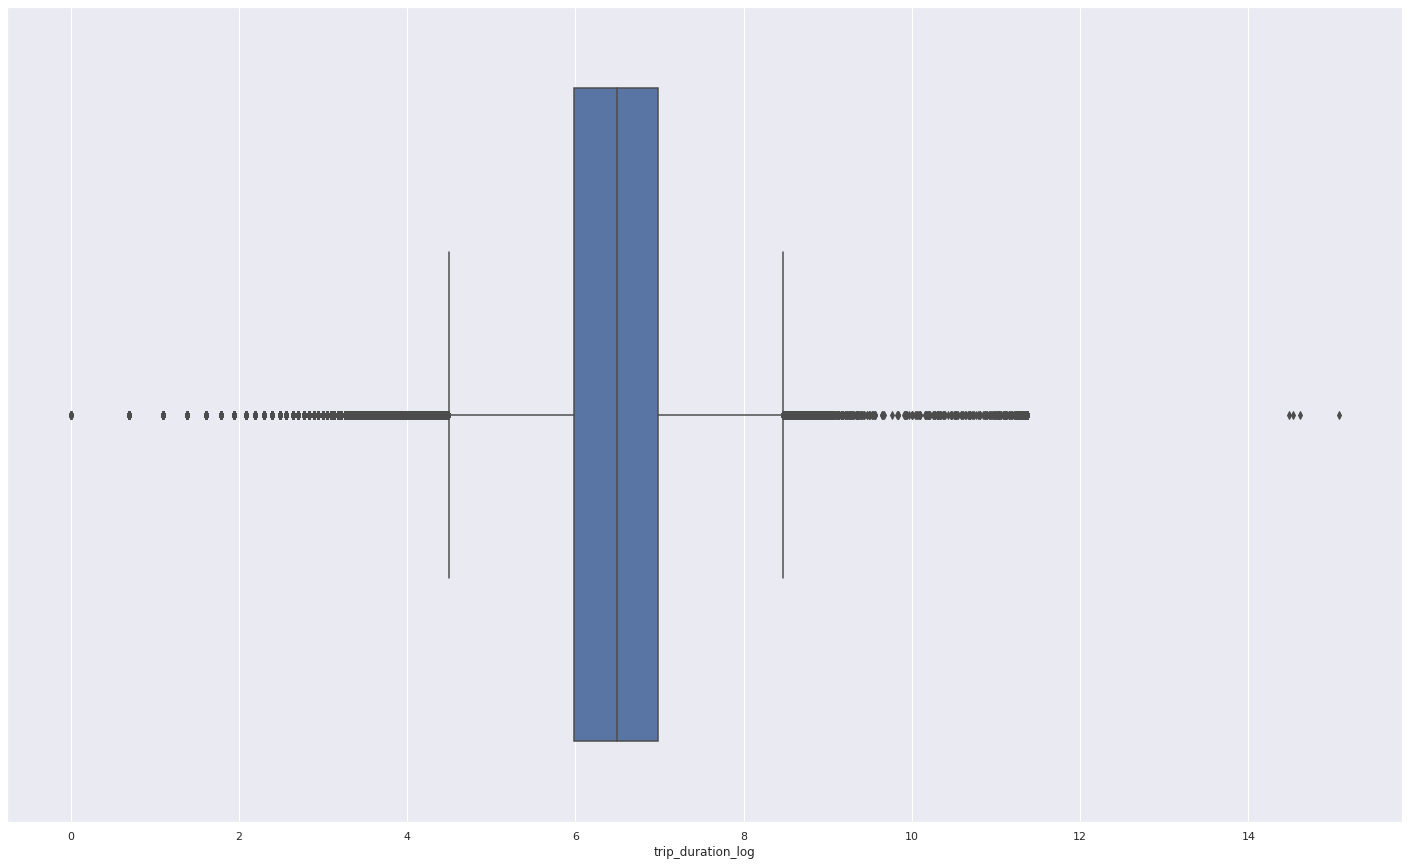

In [213]:
#!g2.1
# Для сравнения
sns.boxplot(x='trip_duration_log', data=data)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ:**
Да, признаки получились хорошими.
В часы, когда дороги загружены, длительность поездки действительно больше, а когда свободны - меньше.

Длительность поездок до аэропортов очень велика по сравнению со средними значениями для всех поездок, потому что аэропорты далеко от города. Особенно это касается аэропорта John F. Kennedy, который дальше от города, чем La Guardia.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [214]:
#!g2.1
from sklearn.base import BaseEstimator, TransformerMixin

# Границы области, которую разбиваем на квадраты - квантили координат
# Дальше - разбить интервалы по lan и lat на равные части

class MapGridTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        lat_series = pd.concat([X['pickup_latitude'], X['dropoff_latitude']], axis=0)
        lon_series = pd.concat([X['pickup_longitude'], X['dropoff_longitude']],)
        borders_quantile_end = 1 - self.borders_quantile
        self.lat_border_start = lat_series.quantile(self.borders_quantile)
        self.lat_border_end = lat_series.quantile(borders_quantile_end)
        self.lon_border_start = lon_series.quantile(self.borders_quantile)
        self.lon_border_end = lon_series.quantile(borders_quantile_end)
        
        self.lat_cell_length = (self.lat_border_end - self.lat_border_start) / self.lat_cells_count
        self.lon_cell_length = (self.lon_border_end - self.lon_border_start) / self.lon_cells_count
        return self

    def transform(self, X, y=None):
        result_data = data.copy()

        result_data['pickup_cell'] = -1
        result_data['dropoff_cell'] = -1

        view_with_valid_pickup_coords = result_data[(result_data['pickup_latitude'] < self.lat_border_end) & (result_data['pickup_latitude'] > self.lat_border_start) & (result_data['pickup_longitude'] < self.lon_border_end) & (result_data['pickup_longitude'] > self.lon_border_start)]
        #print(view_with_valid_pickup_coords)
        view_with_valid_dropoff_coords = result_data[(result_data['dropoff_latitude'] < self.lat_border_end) & (result_data['dropoff_latitude'] > self.lat_border_start) & (result_data['dropoff_longitude'] < self.lon_border_end) &  (result_data['dropoff_longitude'] > self.lon_border_start)]

        # Intentional assigning to view
        
        result_data.loc[view_with_valid_pickup_coords.index, 'pickup_cell'] = (result_data['pickup_latitude'] - self.lat_border_start) // self.lat_cell_length + (result_data['pickup_longitude'] - self.lon_border_start) // self.lon_cell_length
        result_data.loc[view_with_valid_dropoff_coords.index, 'dropoff_cell'] = (result_data['dropoff_latitude'] - self.lat_border_start) // self.lat_cell_length + (result_data['dropoff_longitude'] - self.lon_border_start) // self.lon_cell_length
        
        # Для линейной регрессии признаки должны быть категориальными, так как не может быть линейной зависимости между временем поездки и номером ячейки
        result_data['pickup_cell'] = result_data['pickup_cell'].astype(int).astype('category')
        result_data['dropoff_cell'] = result_data['dropoff_cell'].astype(int).astype('category')
        return result_data

    def __init__(self, borders_quantile=0.1, lat_cells_count=3, lon_cells_count=4):
        self.lon_cells_count = lon_cells_count
        self.lat_cells_count = lat_cells_count
        self.borders_quantile = borders_quantile
        self.lat_border_start = None
        self.lat_border_end = None
        self.lon_border_start = None
        self.lon_border_end = None
        self.lat_cell_length = None
        self.lon_cell_length = None

In [215]:
#!g2.1
map_grid_transformer = MapGridTransformer()
data = map_grid_transformer.fit_transform(data)

data.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,...,haversine_log,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,trip_duration_log,pickup_cell,dropoff_cell
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,...,0.404478,0,0,0,0,0,0,6.120297,3,4
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,...,0.590842,0,0,0,0,0,0,6.496775,1,0
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,...,1.853967,1,0,0,0,0,0,7.661056,3,-1
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,...,0.395750,0,0,0,0,0,0,6.061457,-1,-1
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,...,0.172766,0,0,0,0,0,0,6.075346,-1,-1


In [216]:
#!g2.1
data.dtypes

vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dayofweek                      int64
month                          int64
hour                           int64
dayofyear                      int64
snowstorm                      int64
memorial_day                   int64
haversine                    float64
haversine_log                float64
time_of_busy_roads             int64
time_of_free_roads             int64
from_la_guardia                int64
to_la_guardia                  int64
from_kennedy                   int64
to_kennedy                     int64
trip_duration_log            float64
pickup_cell                 category
dropoff_cell                category
dtype: object

**Задание 10 **. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, численные признаки отмасштабируйте.

In [217]:
#!g2.1
x_train, x_test, y_train, y_test = split_data(scale_and_one_hot_encode(data), 0.3)

In [218]:
#!g2.1
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [219]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, ridge.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, ridge.predict(x_test)))

MSE на train:
32153264.425898246
MSE на test:
7734352.734665585


In [220]:
#!g2.1
#from sklearn.ensemble import RandomForestRegressor

#rfr = RandomForestRegressor()
#rfr.fit(x_train, y_train)

In [221]:
#!g2.1
#print('MSE на train:')
#print(mean_squared_error(y_train, ridge.predict(x_train)))

#print('MSE на test:')
#print(mean_squared_error(y_test, ridge.predict(x_test)))

## 3. Изучаем оставшиеся признаки (1 балл)

**Задание **. Исследуйте признаки `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [222]:
#!g2.1
unique = data['vendor_id'].unique()
unique, len(unique)

(array([2, 1]), 2)

In [223]:
#!g2.1
unique = data['passenger_count'].unique()
unique, len(unique)

(array([1, 6, 4, 2, 3, 5, 0, 7]), 8)

In [224]:
#!g2.1
unique = data['store_and_fwd_flag'].unique()
unique, len(unique)

(array(['N', 'Y'], dtype=object), 2)

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [226]:
#!g2.1
# Maybe there is a better way...
temporary_numeric_to_categorical = data.copy()
temporary_numeric_to_categorical['vendor_id'] = temporary_numeric_to_categorical.apply(lambda x: str(x['vendor_id']), axis=1)
temporary_numeric_to_categorical['passenger_count'] = temporary_numeric_to_categorical.apply(lambda x: str(x['passenger_count']), axis=1)

<AxesSubplot:xlabel='trip_duration_log', ylabel='vendor_id'>

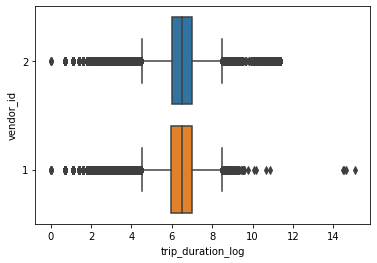

In [227]:
#!g2.1
sns.boxplot(x='trip_duration_log', y='vendor_id', data=temporary_numeric_to_categorical)

<AxesSubplot:xlabel='trip_duration_log', ylabel='passenger_count'>

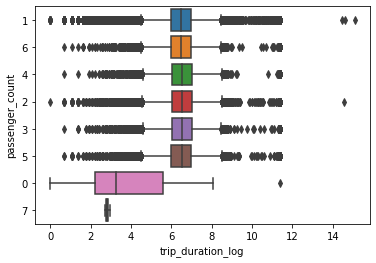

In [228]:
#!g2.1
sns.boxplot(x='trip_duration_log', y='passenger_count', data=temporary_numeric_to_categorical)

<AxesSubplot:xlabel='trip_duration_log', ylabel='store_and_fwd_flag'>

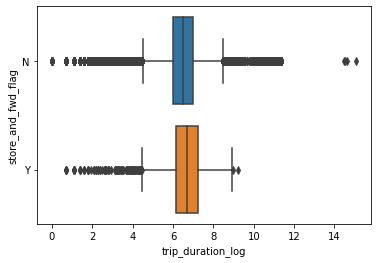

In [229]:
#!g2.1
sns.boxplot(x='trip_duration_log', y='store_and_fwd_flag', data=data)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [230]:
#!g2.1
data['store_and_fwd_flag'] = data.apply(lambda row: 0 if row['store_and_fwd_flag'] == 'N' else 1, axis=1)
data['vendor_id'] = data['vendor_id'] - 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ:**
Распределение trip_duration_log одинаковое для разного количества пассажиров и для разных вендоров.

trip_duration_log вроде как в среднем больше при store_and_fwd_flag == Y, но строк, у которых store_and_fwd_flag == Y, очень мало:

In [231]:
#!g2.1
data.groupby('store_and_fwd_flag').size().to_frame('size')

,size
store_and_fwd_flag,
0,1443331
1,7963


**Задание *. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [232]:
#!g2.1
x_train, x_test, y_train, y_test = split_data(scale_and_one_hot_encode(data), 0.3)

ridge = Ridge()
ridge.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [233]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, ridge.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, ridge.predict(x_test)))

MSE на train:
32177342.644702736
MSE на test:
7998082.05722389


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

##  4. Улучшаем модель

**Задание 13**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

<AxesSubplot:>

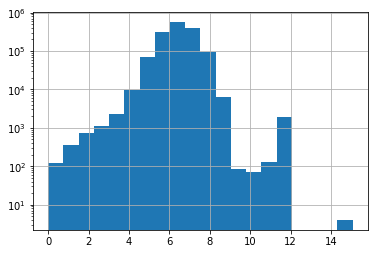

In [234]:
#!g2.1
data['trip_duration_log'].hist(bins = 20, log=True)

In [235]:
#!g2.1
data = data[(0 < data['trip_duration_log']) & (data['trip_duration_log'] <= 12)].copy()

<AxesSubplot:>

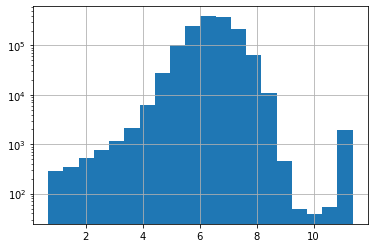

In [236]:
#!g2.1
data['trip_duration_log'].hist(bins = 20, log=True)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [237]:
#!g2.1
data.groupby(['passenger_count']).size()

passenger_count
0         49
1    1028284
2     209300
3      59640
4      28252
5      77733
6      48014
7          2
dtype: int64

In [238]:
#!g2.1
def change_rare_passengers_count(count):
    if count == 0:
        return 1
    elif count == 7:
        return 6
    else:
        return count

data['passenger_count'] = data.apply(lambda x: change_rare_passengers_count(x['passenger_count']), axis=1)
data.groupby(['passenger_count']).size()

passenger_count
1    1028333
2     209300
3      59640
4      28252
5      77733
6      48016
dtype: int64

In [239]:
#!g2.1
data.groupby(['store_and_fwd_flag']).size()

store_and_fwd_flag
0    1443311
1       7963
dtype: int64

In [240]:
#!g2.1
# data.drop('store_and_fwd_flag', axis=1, inplace=True)

In [241]:
#!g2.1
data.groupby(['vendor_id']).size()

vendor_id
0    675491
1    775783
dtype: int64

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [242]:
#!g2.1
def prepare_to_linear_regression(data):
  data_new = data.copy()
  data_new.drop('pickup_datetime', 1, inplace=True)
  data_new.drop('trip_duration_log', 1, inplace=True)
  data_new.drop('pickup_longitude', 1, inplace=True)
  data_new.drop('pickup_latitude', 1, inplace=True)
  data_new.drop('dropoff_longitude', 1, inplace=True)
  data_new.drop('dropoff_latitude', 1, inplace=True)
  data_new.drop('dayofyear', 1, inplace=True)
  data_new.drop('haversine', 1, inplace=True)
  data_new['passenger_count'] = data_new['passenger_count'].astype('category')
  data_new['dayofweek'] = data_new['dayofweek'].astype('category')
  data_new['month'] = data_new['month'].astype('category')
  data_new['hour'] = data_new['hour'].astype('category')
  #data_new['dayofyear'] = data_new['dayofyear'].astype('category')
  return data_new

In [243]:
#!g2.1
prepared_data = prepare_to_linear_regression(data)

In [244]:
#!g2.1
scaled_and_one_hot_encoded = scale_and_one_hot_encode(prepared_data)
data.shape, scaled_and_one_hot_encoded.shape

((1451274, 26), (1451274, 57))

In [245]:
#!g2.1
data.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,...,haversine_log,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,trip_duration_log,pickup_cell,dropoff_cell
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,...,0.404478,0,0,0,0,0,0,6.120297,3,4
1,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,...,0.590842,0,0,0,0,0,0,6.496775,1,0
2,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,...,1.853967,1,0,0,0,0,0,7.661056,3,-1
3,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,...,0.395750,0,0,0,0,0,0,6.061457,-1,-1
4,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,...,0.172766,0,0,0,0,0,0,6.075346,-1,-1


In [246]:
#!g2.1
scaled_and_one_hot_encoded.head()

,vendor_id,store_and_fwd_flag,snowstorm,memorial_day,haversine_log,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,...,34,35,36,37,38,39,40,41,42,trip_duration
0,0.933125,-0.074278,-0.058804,-0.061897,-0.419516,-0.367906,-0.150431,-0.161133,-0.1118,-0.147461,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,455
1,-1.071668,-0.074278,-0.058804,-0.061897,-0.223153,-0.367906,-0.150431,-0.161133,-0.1118,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663
2,0.933125,-0.074278,-0.058804,-0.061897,1.107744,2.718087,-0.150431,-0.161133,-0.1118,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2124
3,0.933125,-0.074278,-0.058804,-0.061897,-0.428712,-0.367906,-0.150431,-0.161133,-0.1118,-0.147461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,429
4,0.933125,-0.074278,-0.058804,-0.061897,-0.663660,-0.367906,-0.150431,-0.161133,-0.1118,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,435


In [247]:
#!g2.1
# Функция для простого разделения на train и test. train_test_split использует слишком много памяти
def manual_split(data, test_size):
    test_rows = int(data.shape[1] * test_size)
    x_train = data.head(data.shape[1] - test_rows)
    x_test = data.tail(test_rows)
    return x_train.drop('trip_duration', axis=1), x_train['trip_duration'], x_test.drop('trip_duration', axis=1), x_test['trip_duration']

In [248]:
#!g2.1
x_train, y_train, x_test, y_test = manual_split(scaled_and_one_hot_encoded, 0.3)

In [249]:
#!g2.1
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [250]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, ridge.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, ridge.predict(x_test)))

MSE на train:
24018.96999684978
MSE на test:
213683.9555133454


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Стало ли лучше?

In [251]:
#!g2.1
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [252]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, lasso.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, lasso.predict(x_test)))

MSE на train:
12708.952277723063
MSE на test:
274704.2044670491


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальное значение параметра регуляризации (по логарифмической сетке), на тестовой выборке измерьте качество полученной модели.

In [253]:
#!g2.1
train = pd.concat([x_train, y_train], axis=1)
train

,vendor_id,store_and_fwd_flag,snowstorm,memorial_day,haversine_log,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,...,34,35,36,37,38,39,40,41,42,trip_duration
0,0.933125,-0.074278,-0.058804,-0.061897,-0.419516,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,455
1,-1.071668,-0.074278,-0.058804,-0.061897,-0.223153,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,663
2,0.933125,-0.074278,-0.058804,-0.061897,1.107744,2.718087,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2124
3,0.933125,-0.074278,-0.058804,-0.061897,-0.428712,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,429
4,0.933125,-0.074278,-0.058804,-0.061897,-0.663660,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,435
5,0.933125,-0.074278,-0.058804,-0.061897,-0.746286,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,443
6,-1.071668,-0.074278,-0.058804,-0.061897,-0.548168,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,341
7,0.933125,-0.074278,-0.058804,-0.061897,0.990919,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1551
8,-1.071668,-0.074278,-0.058804,-0.061897,-0.560897,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,255
9,0.933125,-0.074278,-0.058804,-0.061897,0.875323,-0.367906,-0.150431,-0.161133,-0.111800,-0.147461,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1225


In [254]:
#!g2.1
x_train_new, y_train_new, x_valid, y_valid = manual_split(train, 0.2)
# valid = pd.concat(x_valid, y_valid)

In [255]:
#!g2.1
# Позже я узнал, что существует специальный класс LassoCV. GridSearchCV также выполняет задачу, так что решил не менять уже написанный код.
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': np.arange(1, 100, 1)}
ridge = Lasso()

grid = GridSearchCV(estimator=ridge, param_grid=parameters, scoring='neg_mean_squared_error')
grid.fit(x_valid, y_valid)
best_params = grid.best_params_
best_alpha = best_params['alpha']
best_alpha

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2803.464787135963, tolerance: 330.10979999999995
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1860.5925725416578, tolerance: 384.13300000000004
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3473.713332574953, tolerance: 384.13300000000004
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1962.659

29

In [256]:
#!g2.1
lasso = Lasso(alpha=best_alpha)
lasso.fit(x_train_new, y_train_new)
lasso.coef_

array([ 34.46499098,   0.        ,   0.        ,   0.        ,
       542.49460973,  61.54534675,   0.        ,   0.        ,
        48.99478888,   0.        ,   9.68224927,  55.02576377,
       -39.46773456,  -0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,  -0.        ,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ])

In [257]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train_new, lasso.predict(x_train_new)))

print('MSE на test:')
print(mean_squared_error(y_test, lasso.predict(x_test)))

MSE на train:
76117.35049059911
MSE на test:
155065.8914648143


Для каждого перебранного `alpha` посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`.

In [258]:
#!g2.1
zero_coefs_count = np.zeros(100)
for i in np.arange(1, 100, 1):
    lasso = Lasso(alpha=i)
    lasso.fit(x_train_new, y_train_new)
    zero_coefs_count[i - 1] = len(list(filter(lambda x: x != 0, lasso.coef_)))


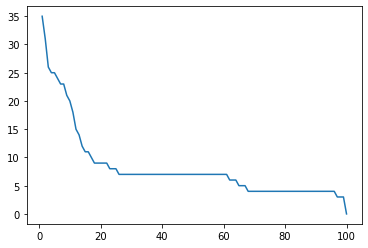

In [259]:
#!g2.1
plt.plot(range(1, len(zero_coefs_count) + 1), zero_coefs_count)

Можно заметить, что при оптимальном alpha количество ненулевых коэффициентов наименьшее.

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими редкими парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

**Ответ:** Такой новый признак будет являться комбинацией уже имеющихся признаков. А в линейной регрессии все признаки рассматриваются независимо.

In [260]:
#!g2.1
def most_frequent_pair(pickup_cell, dropoff_cell, most_frequent_pairs):
    size_arr = most_frequent_pairs[(most_frequent_pairs['pickup_cell'] == pickup_cell) & (most_frequent_pairs['dropoff_cell'] == dropoff_cell)].reset_index()
    #print(size_arr)
    if len(size_arr) == 0:
        return -1
    return size_arr.loc[0,'index']

In [261]:
#!g2.1
#most_frequent_pairs = data.groupby(['pickup_cell', 'dropoff_cell'], as_index = False).size().sort_values('size').head(100)
#most_frequent_pairs

ValueError: No axis named size for object type <class 'pandas.core.series.Series'>

In [262]:
#!g2.1
data

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,...,haversine_log,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,trip_duration_log,pickup_cell,dropoff_cell
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,...,0.404478,0,0,0,0,0,0,6.120297,3,4
1,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,...,0.590842,0,0,0,0,0,0,6.496775,1,0
2,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,...,1.853967,1,0,0,0,0,0,7.661056,3,-1
3,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,...,0.395750,0,0,0,0,0,0,6.061457,-1,-1
4,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,...,0.172766,0,0,0,0,0,0,6.075346,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,...,0.203006,0,0,0,0,0,0,6.656727,2,1
1458640,0,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,0,655,6,...,1.800031,0,1,0,0,0,0,6.484635,1,-1
1458641,1,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,...,2.057273,0,0,0,0,0,0,6.638568,5,-1
1458642,0,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,...,0.088527,0,0,0,0,0,0,5.921578,2,3


In [263]:
#!g2.1
#data['most_frequent_pairs'] = data.apply(lambda x: most_frequent_pair(x['pickup_cell'], x['dropoff_cell'], most_frequent_pairs), axis=1).astype('category')
#data_most_frequent_pairs = data.head(5).apply(lambda x: most_frequent_pair(x['pickup_cell'], x['dropoff_cell'], most_frequent_pairs), axis=1).astype('category')
#data #_most_frequent_pairs

NameError: ("name 'most_frequent_pairs' is not defined", 'occurred at index 0')

Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [269]:
#!g2.1
prepared_data = prepare_to_linear_regression(data)
scaled_and_one_hot_encoded = scale_and_one_hot_encode(prepared_data)
data.shape, scaled_and_one_hot_encoded.shape
x_train, y_train, x_test, y_test = manual_split(scaled_and_one_hot_encoded, 0.3)

lasso = Lasso(alpha=best_alpha)
lasso.fit(x_train, y_train)

Lasso(alpha=29, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [270]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, lasso.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, lasso.predict(x_test)))

MSE на train:
76117.35049059911
MSE на test:
155065.8914648143


**Задание 16**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

Улицы Манхэттена направлены под углом 29° к меридиану. 

Сначала я думал, что систему координат нужно повернуть на 90° - 29° = 61° и пересчитать координаты точек начала и конца поездки в новой системе координат.

https://ru.wikipedia.org/wiki/Генеральный_план_Манхэттена

Старая версия алгоритма:


In [271]:
#!g2.1
from math import sin, cos

manhattan_angle = radians(61)
manhattan_sin = sin(manhattan_angle)
manhattan_cos = cos(manhattan_angle)
longitude_km = 110.574
latitude_km_coefficient = 111.320

def manhattan_coordinates(x, y):
    new_x = x * manhattan_cos - y * manhattan_sin
    new_y = y * manhattan_cos + x * manhattan_sin
    return new_x, new_y

def manhattan_distance_old(x1, y1, x2, y2):
    mx1, my1 = manhattan_coordinates(x1, y1)
    mx2, my2 = manhattan_coordinates(x2, y2)
    dx = abs(mx1 - mx2) # Good enough for New York
    dy = abs(my1 - my2)
    return latitude_km_coefficient * cos(radians(dx)) + longitude_km * dy


Но потом я понял, что по теореме Пифагора манхэттенское расстояние не зависит от направления системы координат.

In [272]:
#!g2.1
from math import sin, cos

longitude_km = 110.574
latitude_km_coefficient = 111.320

def manhattan_distance(x1, y1, x2, y2):
    dx = abs(x1 - x2) # Good enough for New York
    dy = abs(y1 - y2)
    return latitude_km_coefficient * cos(radians(dx)) + longitude_km * dy

data['manhattan_distance'] = data.apply(lambda x: manhattan_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
data

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,...,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,trip_duration_log,pickup_cell,dropoff_cell,manhattan_distance
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,...,0,0,0,0,0,0,6.120297,3,4,113.257778
1,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,...,0,0,0,0,0,0,6.496775,1,0,113.428187
2,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,...,1,0,0,0,0,0,7.661056,3,-1,114.228727
3,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,...,0,0,0,0,0,0,6.061457,-1,-1,111.566332
4,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,...,0,0,0,0,0,0,6.075346,-1,-1,111.334339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,...,0,0,0,0,0,0,6.656727,2,1,112.725458
1458640,0,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,0,655,6,...,0,1,0,0,0,0,6.484635,1,-1,114.721405
1458641,1,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,...,0,0,0,0,0,0,6.638568,5,-1,116.329308
1458642,0,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,...,0,0,0,0,0,0,5.921578,2,3,112.143365


In [273]:
#!g2.1
data = data[data['manhattan_distance'] > 0].copy()

In [274]:
#!g2.1
data['manhattan_distance_log'] = data.apply(lambda x: log(x['manhattan_distance']), axis=1)

In [275]:
#!g2.1
print(data['manhattan_distance_log'].corr(data['trip_duration_log']))
print(data['haversine_log'].corr(data['trip_duration_log']))

0.5437898817027316
0.7739636193972944


In [276]:
#!g2.1
print(data['manhattan_distance'].corr(data['trip_duration']))
print(data['haversine'].corr(data['trip_duration']))

0.14960680162411677
0.16581982014781643


Направления улиц Манхэттена

In [277]:
#!g2.1
# from ipyleaflet import Polyline 
# # Из-за особенностей сферической геометрии 29 и 90+29 тут не подходят. Значения получены экспериментально
# manhattan_angle_x =  radians(113)
# manhattan_angle_y =  radians(36)

# def show_manhattan_street_direction_on_map(color):
#     """
#     The function draws map with circles on it.
#     The center of the map is the mean of coordinates passed in data.
    
#     data: DataFrame that contains columns latitude_column and longitude_column
#     latitude_column: string, the name of column for latitude coordinates
#     longitude_column: string, the name of column for longitude coordinates
#     color: string, the color of circles to be drawn
#     """

#     center = (40.74887, -73.96804)
#     result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

#     lines = []
#     lines.append(Polyline(
#         locations=((center[0] - 0.1*cos(manhattan_angle_x), center[1] - 0.1*sin(manhattan_angle_x)), (center[0] + 0.1*cos(manhattan_angle_x), center[1] + 0.1*sin(manhattan_angle_x))),
#         fill_color=color,
#         fill_opacity=1,
#     ))
#     lines.append(Polyline(
#         locations=((center[0] - 0.1*cos(manhattan_angle_y), center[1] - 0.1*sin(manhattan_angle_y)), (center[0] + 0.1*cos(manhattan_angle_y), center[1] + 0.1*sin(manhattan_angle_y))),
#         fill_color=color,
#         fill_opacity=1,
#     ))
#     circles_layer = LayerGroup(layers=lines)
#     result_map.add_layer(circles_layer)

#     return result_map

In [278]:
#!g2.1
#show_manhattan_street_direction_on_map("blue")

Направление системы координат манхэттенского расстояния

In [279]:
#!g2.1
# from ipyleaflet import Polyline 
# # Из-за особенностей сферической геометрии 29 и 90+29 тут не подходят. Значения получены экспериментально
# manhattan_angle_x =  0
# manhattan_angle_y =  radians(90)

# def show_manhattan_coordinates_on_map(color):
#     """
#     The function draws map with circles on it.
#     The center of the map is the mean of coordinates passed in data.
    
#     data: DataFrame that contains columns latitude_column and longitude_column
#     latitude_column: string, the name of column for latitude coordinates
#     longitude_column: string, the name of column for longitude coordinates
#     color: string, the color of circles to be drawn
#     """

#     center = (40.74887, -73.96804)
#     result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

#     lines = []
#     lines.append(Polyline(
#         locations=((center[0] - 0.1*cos(manhattan_angle_x), center[1] - 0.1*sin(manhattan_angle_x)), (center[0] + 0.1*cos(manhattan_angle_x), center[1] + 0.1*sin(manhattan_angle_x))),
#         fill_color=color,
#         fill_opacity=1,
#     ))
#     lines.append(Polyline(
#         locations=((center[0] - 0.1*cos(manhattan_angle_y), center[1] - 0.1*sin(manhattan_angle_y)), (center[0] + 0.1*cos(manhattan_angle_y), center[1] + 0.1*sin(manhattan_angle_y))),
#         fill_color=color,
#         fill_opacity=1,
#     ))
#     circles_layer = LayerGroup(layers=lines)
#     result_map.add_layer(circles_layer)

#     return result_map

In [280]:
#!g2.1
#show_manhattan_coordinates_on_map("blue")

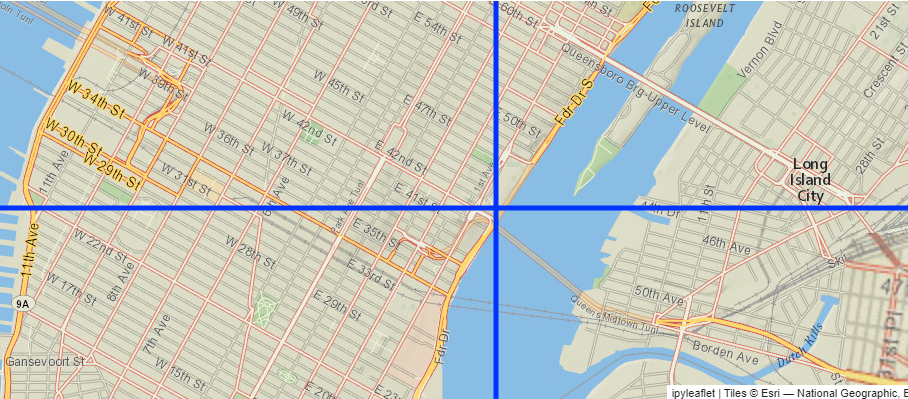

Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [281]:
#!g2.1
prepared_data = prepare_to_linear_regression(data)
scaled_and_one_hot_encoded = scale_and_one_hot_encode(prepared_data)
data.shape, scaled_and_one_hot_encoded.shape
x_train, y_train, x_test, y_test = manual_split(scaled_and_one_hot_encoded, 0.3)

lasso = Lasso(alpha=best_alpha)
lasso.fit(x_train, y_train)

Lasso(alpha=29, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [282]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, lasso.predict(x_train)))

print('MSE на test:')
print(mean_squared_error(y_test, lasso.predict(x_test)))

MSE на train:
73771.49761640134
MSE на test:
159821.69817811123


In [284]:
#!g2.1
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [285]:
#!g2.1
data

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,...,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,trip_duration_log,pickup_cell,dropoff_cell,manhattan_distance,manhattan_distance_log
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,...,0,0,0,0,0,6.120297,3,4,113.257778,4.729666
1,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,...,0,0,0,0,0,6.496775,1,0,113.428187,4.731170
2,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,...,0,0,0,0,0,7.661056,3,-1,114.228727,4.738203
3,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,...,0,0,0,0,0,6.061457,-1,-1,111.566332,4.714619
4,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,...,0,0,0,0,0,6.075346,-1,-1,111.334339,4.712538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,...,0,0,0,0,0,6.656727,2,1,112.725458,4.724955
1458640,0,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,0,655,6,...,1,0,0,0,0,6.484635,1,-1,114.721405,4.742507
1458641,1,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,...,0,0,0,0,0,6.638568,5,-1,116.329308,4.756425
1458642,0,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,...,0,0,0,0,0,5.921578,2,3,112.143365,4.719778


In [286]:
#!g2.1
def prepare_to_catboost(data):
  data_new = data.copy()
  data_new.drop('pickup_datetime', 1, inplace=True)
  data_new.drop('trip_duration_log', 1, inplace=True)
  data_new['pickup_cell'] = data_new['pickup_cell'].astype('int')
  data_new['dropoff_cell'] = data_new['dropoff_cell'].astype('int')
  #data_new.drop('pickup_longitude', 1, inplace=True)
  #data_new.drop('pickup_latitude', 1, inplace=True)
  #data_new.drop('dropoff_longitude', 1, inplace=True)
  #data_new.drop('dropoff_latitude', 1, inplace=True)
  #data_new.drop('dayofyear', 1, inplace=True)
  #data_new.drop('haversine', 1, inplace=True)
  #data_new['passenger_count'] = data_new['passenger_count'].astype('category')
  #data_new['dayofweek'] = data_new['dayofweek'].astype('category')
  #data_new['month'] = data_new['month'].astype('category')
  #data_new['hour'] = data_new['hour'].astype('category')
  #data_new['dayofyear'] = data_new['dayofyear'].astype('category')
  return data_new

In [287]:
#!g2.1
prepared = prepare_to_catboost(data)

In [288]:
#!g2.1
prepared

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dayofweek,month,...,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,pickup_cell,dropoff_cell,manhattan_distance,manhattan_distance_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,3,...,0,0,0,0,0,0,3,4,113.257778,4.729666
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,6,...,0,0,0,0,0,0,1,0,113.428187,4.731170
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,1,...,1,0,0,0,0,0,3,-1,114.228727,4.738203
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,4,...,0,0,0,0,0,0,-1,-1,111.566332,4.714619
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,3,...,0,0,0,0,0,0,-1,-1,111.334339,4.712538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,...,0,0,0,0,0,0,2,1,112.725458,4.724955
1458640,0,1,-74.000946,40.747379,-73.970184,40.796547,0,655,6,1,...,0,1,0,0,0,0,1,-1,114.721405,4.742507
1458641,1,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,...,0,0,0,0,0,0,5,-1,116.329308,4.756425
1458642,0,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,...,0,0,0,0,0,0,2,3,112.143365,4.719778


In [289]:
#!g2.1
prepared.dtypes

vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag          int64
trip_duration               int64
dayofweek                   int64
month                       int64
hour                        int64
dayofyear                   int64
snowstorm                   int64
memorial_day                int64
haversine                 float64
haversine_log             float64
time_of_busy_roads          int64
time_of_free_roads          int64
from_la_guardia             int64
to_la_guardia               int64
from_kennedy                int64
to_kennedy                  int64
pickup_cell                 int64
dropoff_cell                int64
manhattan_distance        float64
manhattan_distance_log    float64
dtype: object

In [290]:
#!g2.1
prepared.shape

(1451274, 26)

In [291]:
#!g2.1
categorical_features_indices = [7, 8, 9, 10, 21,22]

In [292]:
#!g2.1
from catboost import CatBoostRegressor, Pool

x_train, x_test, y_train, y_test = split_data(prepared, 0.3)

In [293]:
#!g2.1
x_train

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofweek,month,hour,...,time_of_busy_roads,time_of_free_roads,from_la_guardia,to_la_guardia,from_kennedy,to_kennedy,pickup_cell,dropoff_cell,manhattan_distance,manhattan_distance_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,0,3,17,...,0,0,0,0,0,0,3,4,113.257778,4.729666
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,6,6,0,...,0,0,0,0,0,0,1,0,113.428187,4.731170
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,1,1,11,...,1,0,0,0,0,0,3,-1,114.228727,4.738203
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,2,4,19,...,0,0,0,0,0,0,-1,-1,111.566332,4.714619
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,5,3,13,...,0,0,0,0,0,0,-1,-1,111.334339,4.712538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021083,0,2,-73.970741,40.794205,-73.974739,40.752602,0,5,6,12,...,0,0,0,0,0,0,-1,3,111.762024,4.716372
1021084,0,1,-73.979874,40.781048,-73.972595,40.797466,0,1,3,15,...,0,0,0,0,0,0,3,-1,112.124802,4.719613
1021085,0,1,-73.977211,40.751728,-73.965309,40.754837,0,2,4,16,...,0,0,0,0,0,0,2,3,112.636036,4.724162
1021086,0,1,-73.985092,40.732201,-73.985092,40.754345,0,1,1,14,...,0,0,0,0,0,0,1,2,111.319992,4.712409


In [302]:
#!g2.1
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)

cat = CatBoostRegressor(loss_function='RMSE')

cat.fit(train_pool)
#cat.fit(x_train, y_train)

Learning rate set to 0.13385
0:	learn: 3167.2478509	total: 256ms	remaining: 4m 15s
1:	learn: 3158.5876762	total: 431ms	remaining: 3m 34s
2:	learn: 3152.1595564	total: 616ms	remaining: 3m 24s
3:	learn: 3147.0198791	total: 789ms	remaining: 3m 16s
4:	learn: 3142.8375937	total: 961ms	remaining: 3m 11s
5:	learn: 3139.5120128	total: 1.14s	remaining: 3m 8s
6:	learn: 3137.0576371	total: 1.3s	remaining: 3m 4s
7:	learn: 3134.9238716	total: 1.47s	remaining: 3m 1s
8:	learn: 3133.0963522	total: 1.65s	remaining: 3m 1s
9:	learn: 3131.7002038	total: 1.81s	remaining: 2m 59s
10:	learn: 3130.4343939	total: 1.98s	remaining: 2m 58s
11:	learn: 3129.5109621	total: 2.16s	remaining: 2m 58s
12:	learn: 3128.7145211	total: 2.34s	remaining: 2m 57s
13:	learn: 3128.0461607	total: 2.51s	remaining: 2m 56s
14:	learn: 3127.5403650	total: 2.67s	remaining: 2m 55s
15:	learn: 3127.0166343	total: 2.81s	remaining: 2m 52s
16:	learn: 3126.5974581	total: 3s	remaining: 2m 53s
17:	learn: 3126.1958863	total: 3.18s	remaining: 2m 53s

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: train_pool
  warnings.warn(message)


In [306]:
#!g2.1
print('MSE на train:')
print(mean_squared_error(y_train, cat.predict(x_train), squared=False))

print('MSE на test:')
print(mean_squared_error(y_test, cat.predict(x_test), squared=False))

MSE на train:
3096.0030959916367
MSE на test:
3115.51768143352


In [296]:
#!g2.1


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:859: UserWarning: The following variables cannot be serialized: train_pool
  warnings.warn(message)
